# **Providing data-driven suggestions for HR**

# **PACE stages**


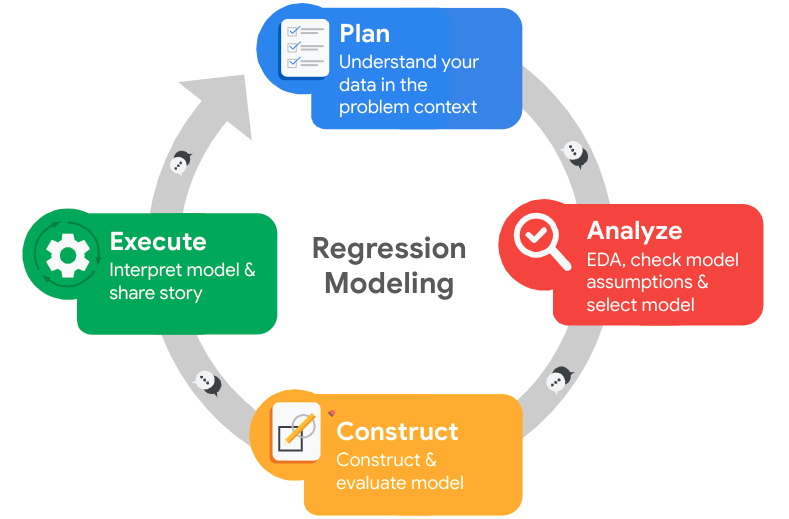

# Pace: Plan Stage

**Note:** For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).
* **satisfaction_level**: Employee-reported job satisfaction level (0–1)
* **last_evaluation**: Score of the employee’s last performance review (0–1)
* **number_project**: Number of projects the employee contributes to
* **average_monthly_hours**: Average number of hours worked per month
* **time_spend_company**: Duration of employment in years
* **Work_accident**: Whether the employee experienced an accident at work
* **left**: Whether the employee left the company
* **promotion_last_5years**: Whether the employee was promoted in the last 5 years
* **Department**: The employee’s department
* **salary**: The employee’s salary (in U.S. dollars)

### Import packages

In [119]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [120]:
# Import data manipulation and visualization packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import scikit-learn packages for model building, evaluation, and preprocessing
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.metrics import (recall_score, precision_score, f1_score, accuracy_score,
                             confusion_matrix, classification_report, ConfusionMatrixDisplay,
                             roc_curve, roc_auc_score, auc, RocCurveDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import XGBoost
from xgboost import XGBClassifier, plot_importance

# Import statsmodels and related utilities
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Other utilities
import pickle  # For model saving and reuse 

### Load dataset

In [121]:
import pandas as pd

In [122]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")

# Display first few rows of the dataframe
df0.head()

satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3              0     1                      0      sales   

   salary  
0     low  
1  medium  
2  medium  
3     low  
4     low

### Gather basic information about the data

In [123]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [124]:
# Gather descriptive statistics about the data
df0.describe(include='all')

satisfaction_level  last_evaluation  number_project  \
count         14999.000000     14999.000000    14999.000000   
unique                 NaN              NaN             NaN   
top                    NaN              NaN             NaN   
freq                   NaN              NaN             NaN   
mean              0.612834         0.716102        3.803054   
std               0.248631         0.171169        1.232592   
min               0.090000         0.360000        2.000000   
25%               0.440000         0.560000        3.000000   
50%               0.640000         0.720000        4.000000   
75%               0.820000         0.870000        5.000000   
max               1.000000         1.000000        7.000000   

        average_montly_hours  time_spend_company  Work_accident          left  \
count           14999.000000        14999.000000   14999.000000  14999.000000   
unique                   NaN                 NaN            NaN           NaN   
top                      NaN                 NaN            NaN           NaN   
freq                     NaN                 NaN            NaN           NaN   
mean              201.050337            3.498233       0.144610      0.238083   
std                49.943099            1.460136       0.351719      0.425924   
min                96.000000            2.000000       0.000000      0.000000   
25%               156.000000            3.000000       0.000000      0.000000   
50%               200.000000            3.000000       0.000000      0.000000   
75%               245.000000            4.000000       0.000000      0.000000   
max               310.000000           10.000000       1.000000      1.000000   

        promotion_last_5years Department salary  
count            14999.000000      14999  14999  
unique                    NaN         10      3  
top                       NaN      sales    low  
freq                      NaN       4140   7316  
mean                 0.021268        NaN    NaN  
std                  0.144281        NaN    NaN  
min                  0.000000        NaN    NaN  
25%                  0.000000        NaN    NaN  
50%                  0.000000        NaN    NaN  
75%                  0.000000        NaN    NaN  
max                  1.000000        NaN    NaN

### Rename columns

I'll standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [125]:
# Display all column names
df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

In [126]:
# Rename columns to be short and readable
df0.rename(columns={
    'satisfaction_level': 'satisfaction',
    'last_evaluation': 'evaluation',
    'number_project': 'projects',
    'average_montly_hours': 'monthly_hours',
    'time_spend_company': 'tenure',
    'Work_accident': 'accident',
    'left': 'left',
    'promotion_last_5years': 'promotion',
    'Department': 'department'}, inplace=True)

# Display all column names after the update
df0.columns

Index(['satisfaction', 'evaluation', 'projects', 'monthly_hours', 'tenure',
       'accident', 'left', 'promotion', 'department', 'salary'],
      dtype='object')

### Check missing values

In [127]:
# Check for missing values
df0.isnull().sum()

satisfaction     0
evaluation       0
projects         0
monthly_hours    0
tenure           0
accident         0
left             0
promotion        0
department       0
salary           0
dtype: int64

The dataset has no null values.

### Check duplicates

In [128]:
# Check for duplicates
df0.duplicated().sum()

3008

In [129]:
# Inspect some rows containing duplicates as needed
df0[df0.duplicated(keep=False)].sort_values(['satisfaction', 'evaluation', 'projects', 'monthly_hours', 'tenure',
       'accident', 'left', 'promotion', 'department', 'salary'])

satisfaction  evaluation  projects  monthly_hours  tenure  accident  \
30             0.09        0.62         6            294       4         0   
12030          0.09        0.62         6            294       4         0   
14241          0.09        0.62         6            294       4         0   
71             0.09        0.77         5            275       4         0   
12071          0.09        0.77         5            275       4         0   
...             ...         ...       ...            ...     ...       ...   
13089          1.00        0.88         6            201       4         0   
11375          1.00        0.93         5            167       3         0   
13586          1.00        0.93         5            167       3         0   
10691          1.00        0.93         5            231       2         0   
12902          1.00        0.93         5            231       2         0   

       left  promotion   department  salary  
30        1          0   accounting     low  
12030     1          0   accounting     low  
14241     1          0   accounting     low  
71        1          0  product_mng  medium  
12071     1          0  product_mng  medium  
...     ...        ...          ...     ...  
13089     0          0    technical     low  
11375     0          0        sales  medium  
13586     0          0        sales  medium  
10691     0          0    marketing  medium  
12902     0          0    marketing  medium  

[5346 rows x 10 columns]

In [130]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df = df0.drop_duplicates(keep = 'first')

# Check if all duplicates were removed
print("Number of duplicated rows removed: ", df0.shape[0] - df.shape[0])

# Display first few rows of new dataframe as needed
df.head()

Number of duplicated rows removed:  3008


satisfaction  evaluation  projects  monthly_hours  tenure  accident  left  \
0          0.38        0.53         2            157       3         0     1   
1          0.80        0.86         5            262       6         0     1   
2          0.11        0.88         7            272       4         0     1   
3          0.72        0.87         5            223       5         0     1   
4          0.37        0.52         2            159       3         0     1   

   promotion department  salary  
0          0      sales     low  
1          0      sales  medium  
2          0      sales  medium  
3          0      sales     low  
4          0      sales     low

### Check outliers

In [131]:
# Define a function to identify, visualize and isolate the outliers in a DataFrame column
def outlier_box_plot(df, column, iqr_factor):
    """
    Analyzes a DataFrame column and returns a DataFrame containing outliers best on a defined interquartile range.

    Args:
        df (pandas.DataFrame): The DataFrame to analyze
        column (str): The column name to analyze
        iqr_factor (float): The factor to use when calculating IQR outlier thresholds

    Returns:
        outliers: A DataFrame containing outliers identified based on IQR.
    """

    # Calculate mean and median of the data
    mean = np.mean(df[column])
    median = np.median(df[column])
    print(f"Mean: {mean}")
    print(f"Median: {median}")
    print()

    # Calculate the 25th percentile (Q1) and 75th percentile (Q3)
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Calculate upper and lower thresholds for outliers
    lower_limit = q1 - iqr_factor * iqr
    upper_limit = q3 + iqr_factor * iqr
    print(f'Lower limit is: {lower_limit}')
    print(f'Upper limit is: {upper_limit}')

    # Create a boxplot of the data to visualize the distribution and outliers
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[column], whis=iqr_factor)
    plt.xlabel('Data')
    plt.title(f'{column} Data Distribution')
    plt.show()

    # Use a Boolean mask to select only the rows of the dataframe that contain outlier values
    outliers = df[(df[column] < lower_limit) | (df[column] > upper_limit)]

    return outliers

Upon applying the outlier detection function unsing an interquartile range of 1.5 ([most closely follows Gaussian distribution](https://builtin.com/articles/1-5-iqr-rule#:~:text=The%20interquartile%20(IQR)%20method%20of,most%20closely%20follows%20Gaussian%20distribution)) to all columns in the dataset, I discovered that only the `tenure` variable contained outlier values.

Mean: 3.3648569760653824
Median: 3.0

Lower limit is: 1.5
Upper limit is: 5.5


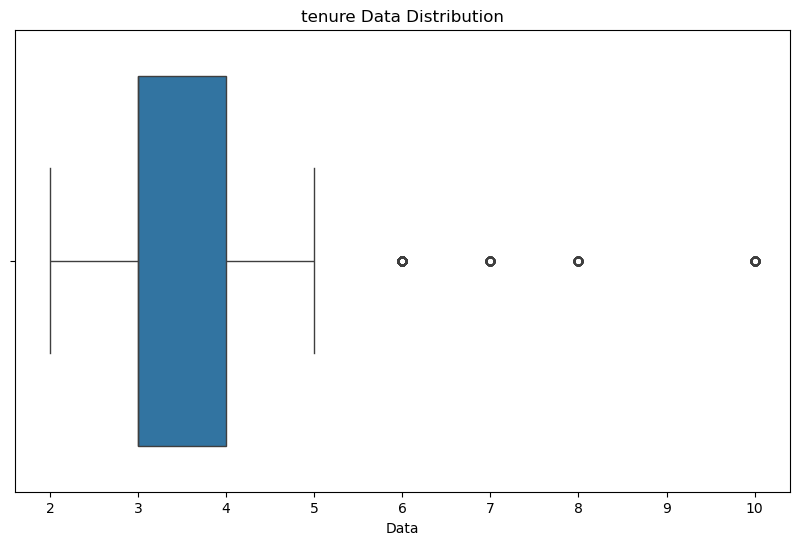

satisfaction  evaluation  projects  monthly_hours  tenure  accident  \
1              0.80        0.86         5            262       6         0   
17             0.78        0.99         4            255       6         0   
34             0.84        0.87         4            246       6         0   
47             0.57        0.70         3            273       6         0   
67             0.90        0.98         4            264       6         0   
...             ...         ...       ...            ...     ...       ...   
11994          0.22        0.94         3            193      10         0   
11995          0.90        0.55         3            259      10         1   
11996          0.74        0.95         5            266      10         0   
11997          0.85        0.54         3            185      10         0   
11998          0.33        0.65         3            172      10         0   

       left  promotion   department  salary  
1         1          0        sales  medium  
17        1          0        sales     low  
34        1          0           hr     low  
47        1          0      support     low  
67        1          0  product_mng  medium  
...     ...        ...          ...     ...  
11994     0          1   management    high  
11995     0          1   management    high  
11996     0          1   management    high  
11997     0          1   management    high  
11998     0          1    marketing    high  

[824 rows x 10 columns]

In [132]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
outlier_box_plot(df, 'tenure', 1.5)

In [133]:
# Print the number of rows where the 'tenure' column value is greater than 5.5, the upper limit of outlier threshold
print(f"Number of outlier rows: {df[df['tenure'] > 5.5].shape[0]} rows")

# Calculate the proportion of rows where the 'tenure' column value is greater than 5.5
print(f"They represent {((df[df['tenure'] > 5.5].shape[0])/df.shape[0]):.2%} of the whole dataset.")

Number of outlier rows: 824 rows
They represent 6.87% of the whole dataset.


When I get to the stage of building the model, I'll consider whether to remove outliers, based on the type of model I decide to use.

# pAce: Analyze Stage (EDA)



left
0    10000
1     1991
Name: count, dtype: int64


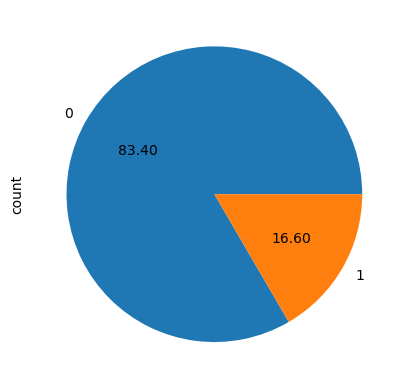

In [134]:
# Get count of employees who left vs. stayed
print(df['left'].value_counts())

# Visulaize percentages of employees who left vs. stayed
df['left'].value_counts().plot.pie(autopct='%.2f');

### Data visualizations

### **1. Univariate Analysis**

Let's start by visualizing the disribution of all variables in the dataset.

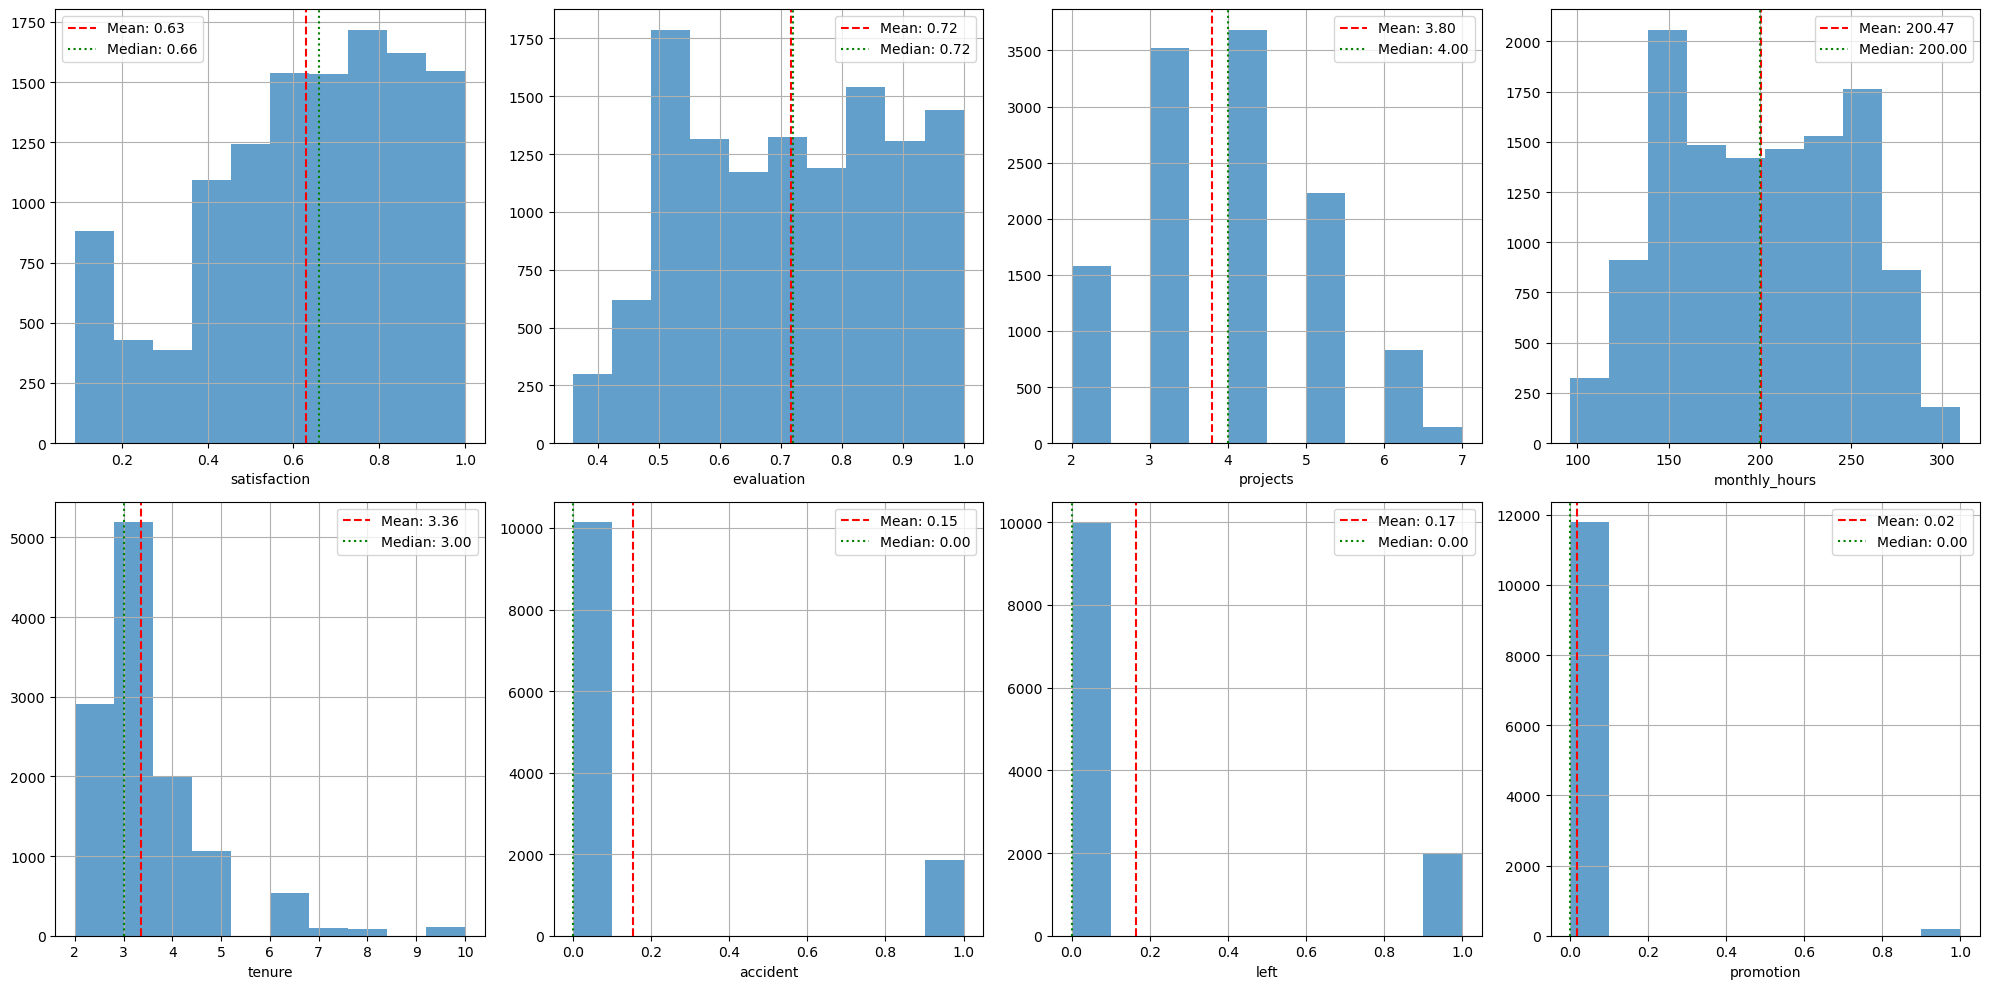

In [135]:
# Create a 2x4 grid of subplots with specified figure size
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# List of columns to plot
cols = ['satisfaction', 'evaluation', 'projects', 'monthly_hours', 'tenure',
        'accident', 'left', 'promotion']

# Loop through columns and plot each in the grid
for idx, col in enumerate(cols):
    ax = axs.flat[idx]

    # Plot histogram
    df[col].hist(ax=ax, alpha=0.7)
    ax.set_xlabel(col)

    # Calculate mean and median
    mean_value = df[col].mean()
    median_value = df[col].median()

    # Add vertical lines for mean (red) and median (green)
    ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5)
    ax.axvline(median_value, color='green', linestyle='dotted', linewidth=1.5)

    # Add legend directly in the loop
    ax.legend([f'Mean: {mean_value:.2f}', f'Median: {median_value:.2f}'])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

Now, let's examine the distribution of all employees across each department. I'll create a function to reuse for generating other bar plots in salary categories:

In [136]:
def make_bar_plot(df, x, y, title):
    """
    Create a bar plot between two variables, sorted by counts of y in descending order.

    Parameters:
    df (DataFrame): The dataset containing the data.
    x (str): The column name for the x-axis.
    y (str): The column name for the y-axis.
    title (str): The title of the plot.
    """
    # Aggregate the data to get the count of all employees
    df_agg = df.groupby(x)[y].count().reset_index()

    # Sort the aggregated data by the count in descending order
    df_sorted = df_agg.sort_values(by=y, ascending=False)

    # Set the figure size
    plt.figure(figsize=(10, 5))

    # plot the barplot
    sns.barplot(df_sorted, x=x, y=y)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=90)

    # Annotate the bars with counts
    ax = plt.gca()
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height() - (p.get_height() * 0.05)),
                    ha='center', va='top',
                    xytext=(0, 0),
                    textcoords='offset points',
                    color='white')

    plt.show()

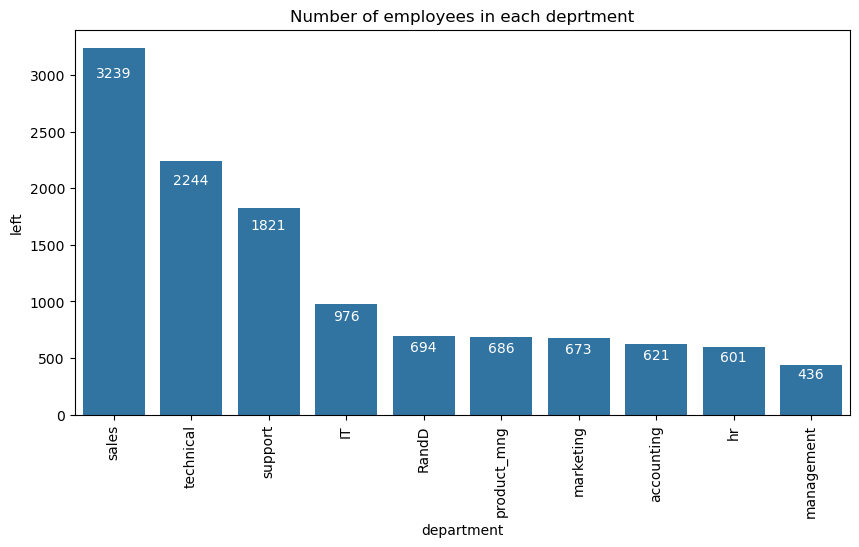

In [137]:
# Apply the bar plot function
make_bar_plot(df, 'department', 'left', 'Number of employees in each deprtment')

In [138]:
# percentage of employees by department
(df['department'].value_counts(normalize=True)*100).round(0).astype(str) + '%'

department
sales          27.0%
technical      19.0%
support        15.0%
IT              8.0%
RandD           6.0%
product_mng     6.0%
marketing       6.0%
accounting      5.0%
hr              5.0%
management      4.0%
Name: proportion, dtype: object

Now, let's examine the distribution of all employees across all salary categories:

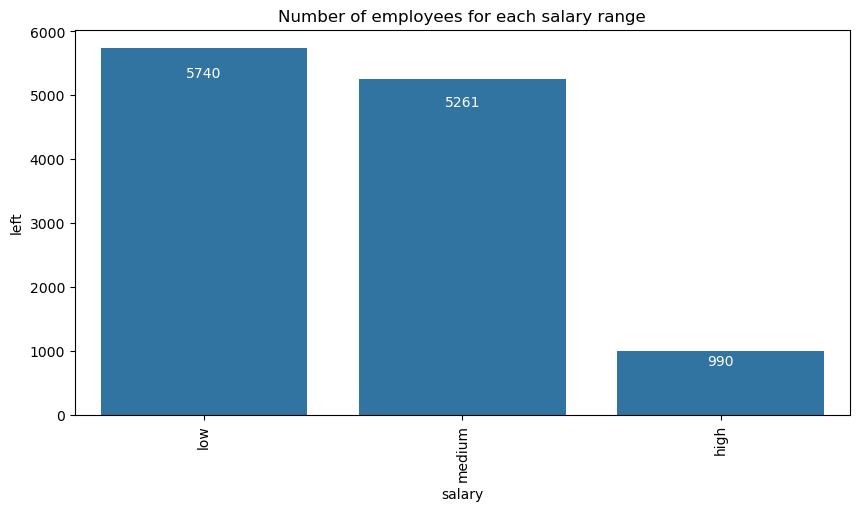

In [139]:
# Apply the bar plot function
make_bar_plot(df, 'salary', 'left', 'Number of employees for each salary range')

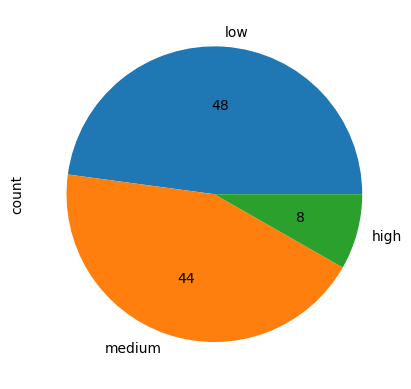

In [140]:
# percentage of employees salary ranges
df['salary'].value_counts().plot.pie(autopct='%.0f');

From the above distributions I can notice the following:

* **Satisfaction**: The majority of employees expressed above average satisfaction with their jobs (from 0.4 and up), though a significant minority reported lower than average levels of satisfaction (between 0 and 0.1).

* **Evaluation**: Employee evaluations generally fell within a positive range, with most scores between 0.5 and 1.

* **Projects**: The typical employee workload involved contributing to 3 to 4 projects.

* **Monthly Hours**: The majority of employees worked approximately 150 to 260 hours per month. Let's assume an employee normal working hours per week is 8 hours for 5 days a week, for 50 out of 52 working weeks per year, that results in around 168 hour per month:

<br>
$$
\frac{50 \text{ weeks} \times 8 \text{ hours/day} \times 5 \text{ days/week}}{12 \text{ months}} = 168 \text{ hours per month}
$$
<br>

and with a median of 200 hours per month, this is higher than the typical monthly working hours, and it should be invistegated more as a potential reason for turnover.

* **Tenure**: Employee tenure was concentrated between three and four years, suggesting a relatively young workforce, with a smaller group of employees having longer tenures exceeding six years.

* **Accidents**: The data indicated a low accident rates in the company.

* **Left**: The majority of surveyed employees remained with the company.

* **Promotions**: Promotions are relatively rare, with most employees not receiving advancements during teh last 5 years.

* **Department**: The sales department is the largest in employee counts, followed by technical and support departments, these three make up around 61% of the company force.

* **Salary**: The majority of employees earn within the low and medium salary ranges, comprising approximately 47% and 44% of the workforce, respectively. Conversely, only a small percentage (8%) fall into the high salary category.

### **2. Bivariate Analysis**

Now, I'll examine the relationships between variables of interest and the employees' turnover:

In [141]:
def make_violin(df, category, var, title):
    """
    Creates a violin plot to visualize the relationship between a categorical binary variable and the continuous variable of interest.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        category (str): The column name for the categorical binary variable.
        var (str): The column name for the continuous variable.
        title (str): The title of the plot.
    """

    # Set the figure size
    plt.figure(figsize=(10, 5))

    # Create a violin plot using seaborn
    fig = sns.violinplot(data=df, x=category, y=var, hue=category, palette='coolwarm')

    # Set the title
    plt.title(title)

    # Set the x-axis labels
    plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

    # Add gridlines
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

    # Display the plot
    plt.show()

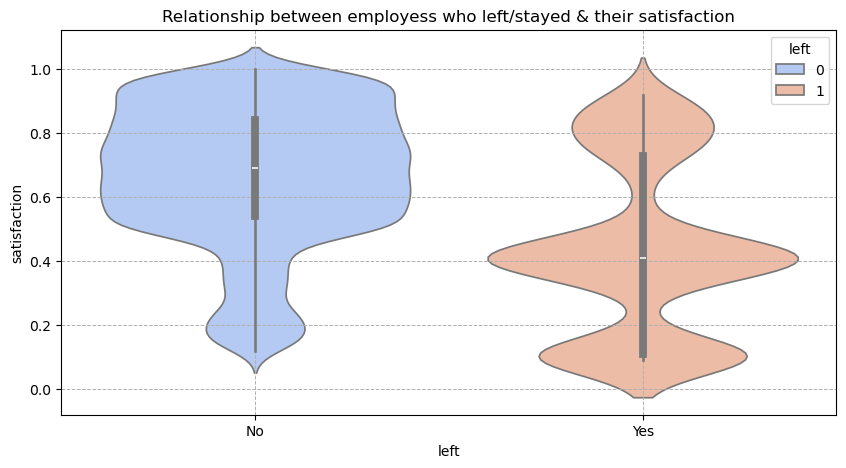

In [142]:
make_violin(df, 'left', 'satisfaction', 'Relationship between employess who left/stayed & their satisfaction')

From the above chart I can observe the follwoing:
* The **majority of employees who left the company reported lower satisfaction levels compared to those who stayed**.
* A portion of employees who left were satisfied.
* A portion of employees who stayed are dissatisfied.

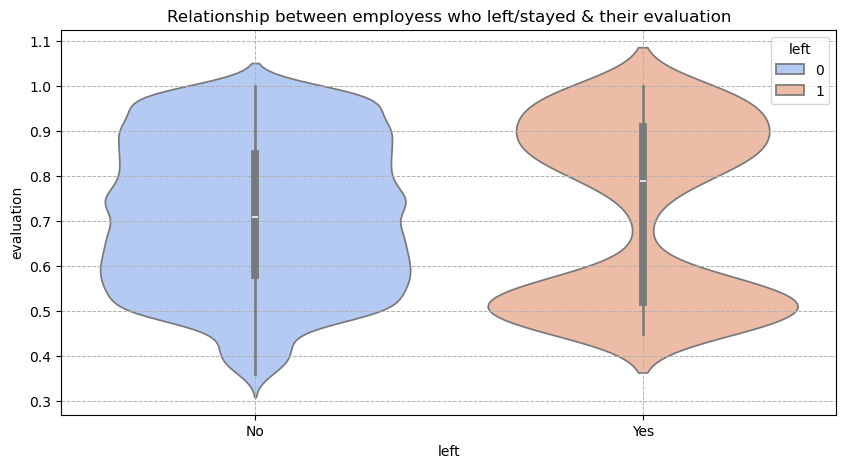

In [143]:
make_violin(df, 'left', 'evaluation', 'Relationship between employess who left/stayed & their evaluation')

From the above chart, I can observe the following:

* There are **two categories of employees who left: those with high evaluations and those with low evaluations.**
* **Average performers are more likely to stay.**

***This could indicate issues with retaining top talent, as well as potential performance-related departures.***

In [144]:
def make_histogram(df, var, category, title):
    """
    Creates a histogram plot to visualize the relationship between a categorical variable and the continuous variable of interest.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    var (str): The column name for the continuous variable.
    category (str): The column name for the categorical variable.
    title (str): The title of the plot.
    """
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Create a histogram of the specified column (x) with category
    ax = sns.histplot(df, x=var, hue=category, multiple='dodge', palette='coolwarm',
                      bins=len(df[var].unique()), shrink=0.8, edgecolor=None)

    # Add values on top of each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Only show the value if height is greater than zero
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='baseline', fontsize=10, color='black',
                        xytext=(0, 3), textcoords='offset points')

    # Add a title to the plot
    plt.title(title)

    # Label the x-axis
    plt.xlabel(var)

    # Label the y-axis
    plt.ylabel('Frequency')

    # Display the plot
    plt.show()

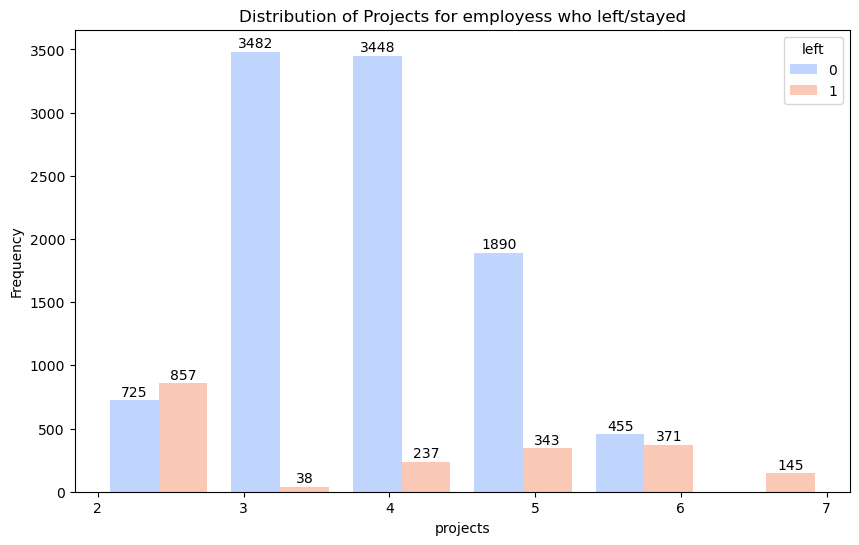

In [145]:
make_histogram(df, 'projects', 'left', 'Distribution of Projects for employess who left/stayed')

The chart reveals several trends:

* **The majority of employees who remained with the company had worked on 3 to 5 projects.**
* **Among those who left, while some had contributed to 4 or more projects, the largest share had worked on 2 projects.**
* **Notably, all employees who contributed to 7 projects have left the company, suggesting that overwork due to multiple projects may be a contributing factor to turnover.**

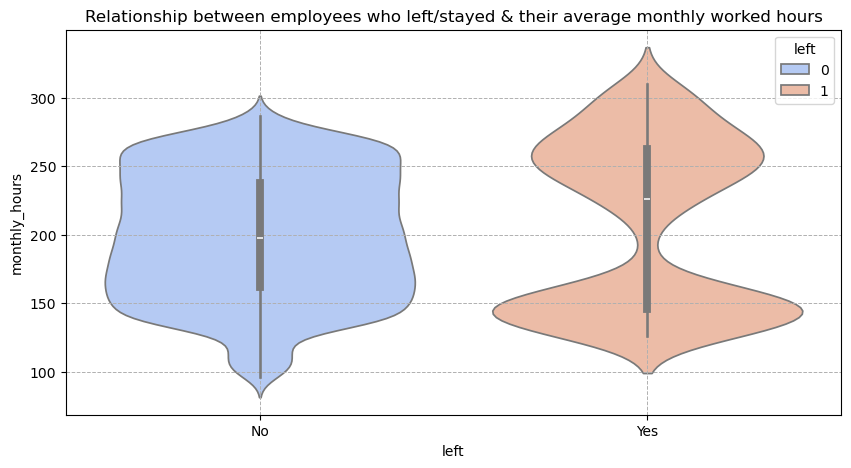

In [146]:
make_violin(df, 'left', 'monthly_hours', 'Relationship between employees who left/stayed & their average monthly worked hours')

This chart mirrors the pattern seen in the plot of employee turnover against evaluations, indicating a strong correlation between evaluations and average monthly hours worked, I'll be checking this later. Notably:

* Employees **working either very high or very low monthly hours were more likely to leave**. Conversely, those **working between 150 to 260 hours per month tended to stay**.
* The chart suggests that underwork (low monthly hours) or overwork (high monthly hours) may contribute to employee departures, while those working an average number of hours are more likely to remain.

***The data indicates that identifying an optimal range of work hours could be crucial for maintaining employee satisfaction and retention.***

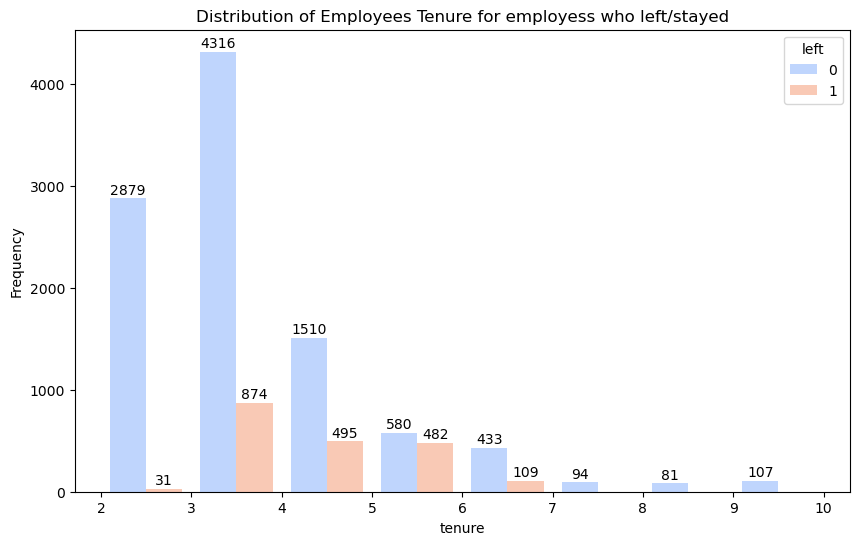

In [147]:
make_histogram(df, 'tenure', 'left', 'Distribution of Employees Tenure for employess who left/stayed')

* The chart reveals that **employees who spent less than 3 years or more than 6 years with the company were more likely to stay.**

* Notably, the **highest rate of departures occurred around the 3-year mark.**

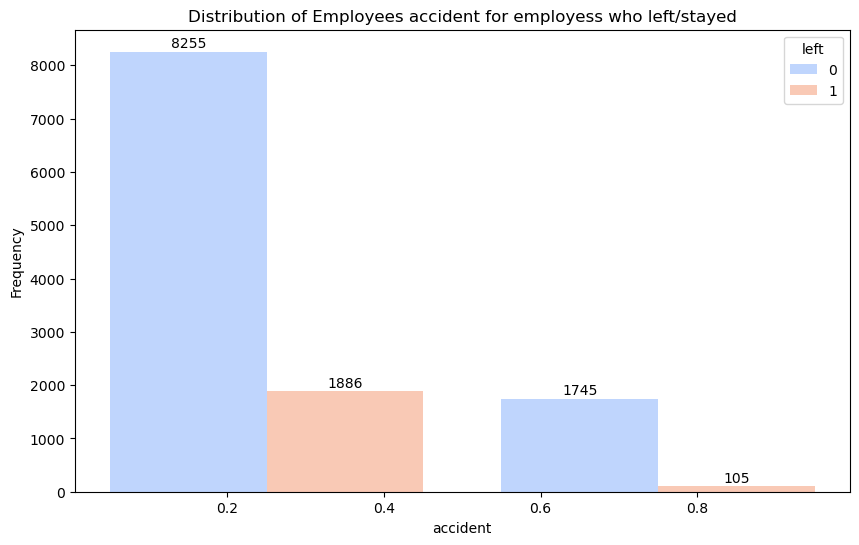

In [148]:
make_histogram(df, 'accident', 'left', 'Distribution of Employees accident for employess who left/stayed')

In [149]:
# View percentages of employees who've had an accident for those who left and who didn't
(df.groupby(['left', 'accident'])['accident'].count() /
df.groupby('left')['accident'].count() * 100).round(0).astype(str) + '%'

left  accident
0     0           83.0%
      1           17.0%
1     0           95.0%
      1            5.0%
Name: accident, dtype: object

The percentage of employees who experienced an accident while working at the company differs between those who stayed and those who left. Specifically, **17% of employees who left had an accident, compared to only 5% of those who remained.**

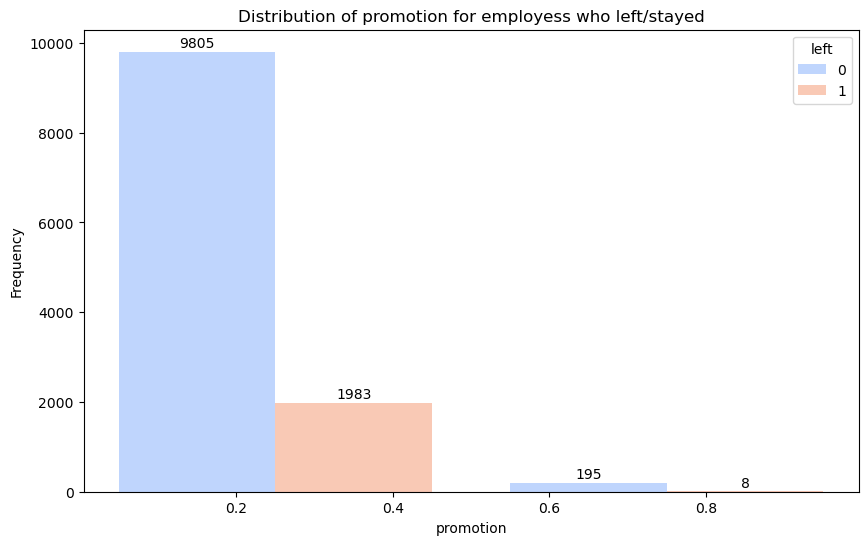

In [150]:
make_histogram(df, 'promotion', 'left', 'Distribution of promotion for employess who left/stayed')

In [151]:
# View percentages of employees who've had a promotion in last 5 years for those who left and who didn't
(df.groupby(['left', 'promotion'])['promotion'].count() /
df.groupby('left')['promotion'].count() * 100).round(2).astype(str) + '%'

left  promotion
0     0            98.05%
      1             1.95%
1     0             99.6%
      1              0.4%
Name: promotion, dtype: object

While the absolute number of employees who left without a promotion is smaller than those who stayed (1983 to 9805), when expressed as a percentage of their respective groups, the **rates are very similar. 98.05% of employees who stayed and 99.6% of those who left did not receive a promotion in the past five years.**

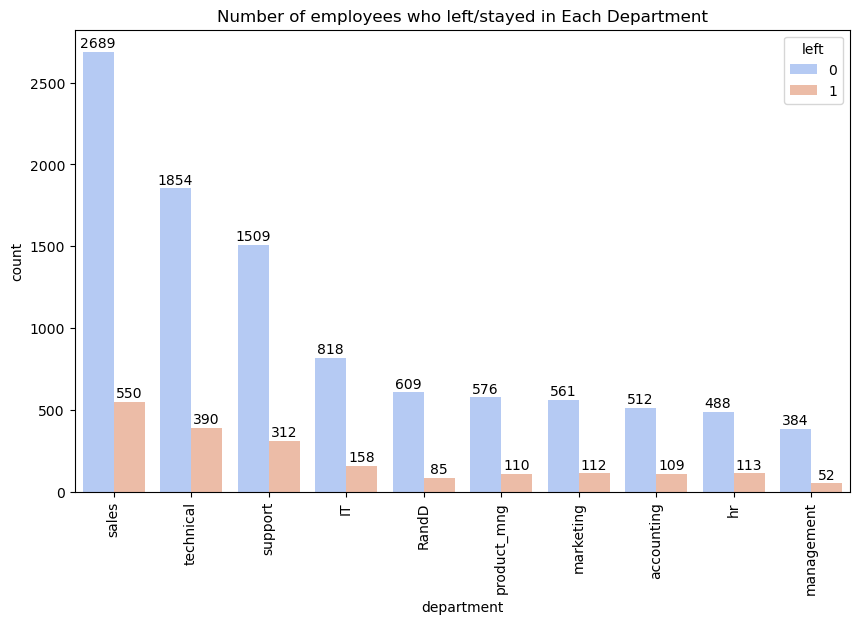

In [152]:
# Group by 'department' and get the count of employees in each department
department_counts = df.groupby('department')['left'].count().reset_index(name='count')

# Sort departments by the count of employees in descending order
department_counts = department_counts.sort_values(by='count', ascending=False)

# Get the sorted list of departments
sorted_departments = department_counts['department'].tolist()

# Create the bar plot using the sorted department list for the x-axis order
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='department', hue='left', order=sorted_departments, palette='coolwarm')

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=10, color='black',
                    xytext=(0, 3), textcoords='offset points')

# Add a title to the plot
plt.title('Number of employees who left/stayed in Each Department')

# Show the plot
plt.show()

Now I want to check the percentages of those who left compared to those who stayed for each department, to see if there's a specific department with high turnover rates.

In [153]:
def make_bar_percentage(df, var, category, title):
    """
    Creates a stacked percentage bar plot to visualize the relationship between a categorical binary variable and another categorical variable of interest.

    Args:
        df: The pandas DataFrame containing the data.
        var (str): The column on the x-axis (categorical variable of interest).
        category (str): The column to categorize on (often 'left' or another binary/categorical variable).
        title (str): The title of the plot.
    """

    # Get counts per vaiable of interest (var) and category
    left_counts = df.groupby([var, category]).size().reset_index(name='count')

    # Get total counts for each var category
    total_counts = df.groupby(var).size().reset_index(name='total_count')

    # Merge to get both counts and total counts for percentage calculation
    left_counts = left_counts.merge(total_counts, on=var)

    # Calculate percentages for each category of var
    left_counts['percentage'] = (left_counts['count'] / left_counts['total_count']) * 100

    # Sort the variable categories by the total counts in descending order
    sorted_groups = total_counts.sort_values(by='total_count', ascending=False)[var].tolist()

    # Pivot to get a DataFrame where each category is in a separate column
    pivot_df = left_counts.pivot(index=var, columns=category, values='percentage').fillna(0)

    # Create the stacked bar plot showing percentages
    plt.figure(figsize=(15, 5))
    ax = pivot_df.loc[sorted_groups].plot(kind='bar', stacked=True, ax=plt.gca(), colormap='coolwarm')

    # Rotate x-axis labels by 90 degrees for better readability
    plt.xticks(rotation=90)

    # Set y-axis limit to 100%
    plt.ylim(0, 100)

    # Add axis labels and title
    plt.xlabel(var)
    plt.ylabel('Percentage')
    plt.title(title)

    # Add percentage labels to the bars
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x_pos, y_pos = p.get_xy()
        if height > 0:  # Only label if the height is greater than 0
            ax.annotate(f'{height:.1f}%', (x_pos + width / 2, y_pos + height / 2), ha='center', va='center', color='white')

    # Show the plot
    plt.show()

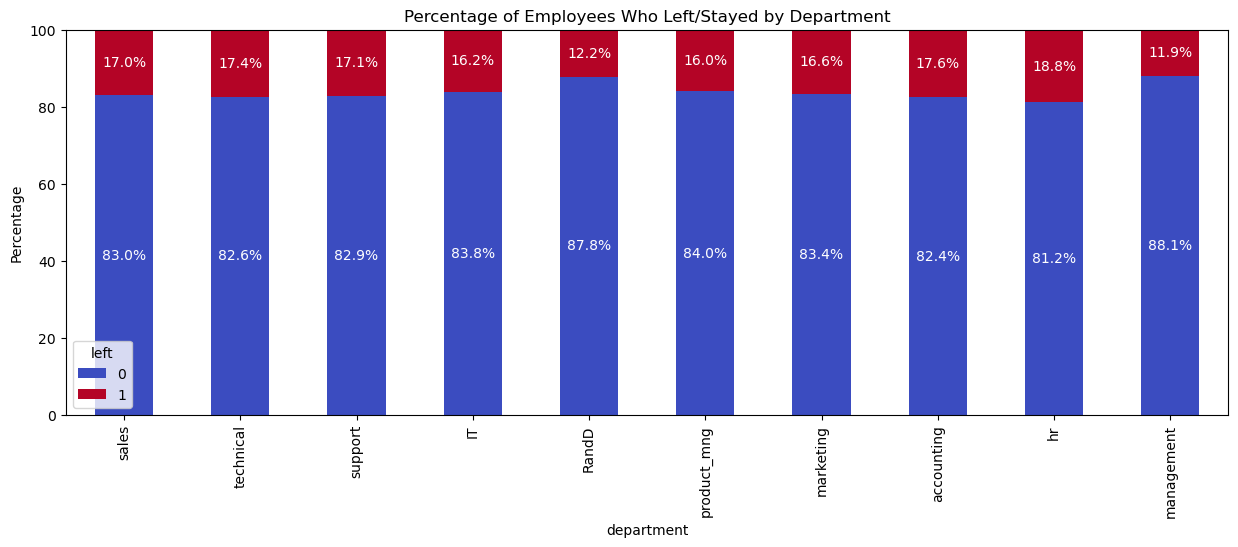

In [154]:
make_bar_percentage(df, 'department', 'left', 'Percentage of Employees Who Left/Stayed by Department')

While the sales department had the highest number of employee departures, this can be attributed to it having the largest workforce overall. Therefore, **no specific department stood out as having a disproportionately high turnover rate.**

Now let's do the same for the salaries:

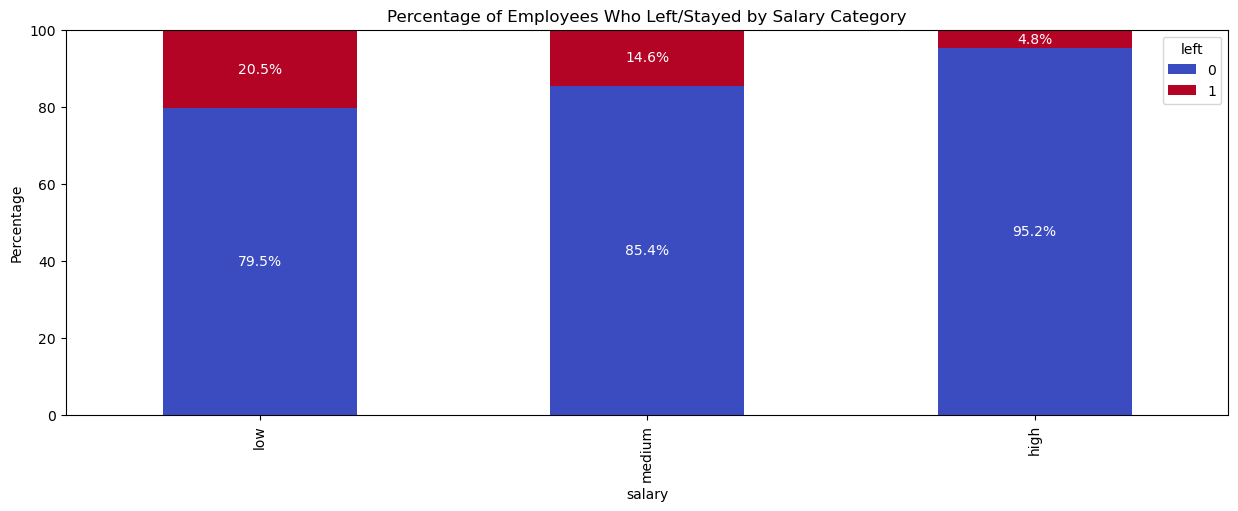

In [155]:
make_bar_percentage(df, 'salary', 'left', 'Percentage of Employees Who Left/Stayed by Salary Category')

**Only the highest-paid employees exhibited low turnover rates. However, the difference in turnover rates between the low and medium salary categories was not so significant.**

### **3. Multivariate Analysis**

Let's check out the realtionship between satisfaction levels and evaluations for employees who left and those who stayed:

In [156]:
def make_scatter(df, x, y, title, vertical_line=None):
    """
    Creates a scatter plot between two continuous variables categorized by employees who left or stayed.

    Args:
        df (pandas.DataFrame): The dataset containing the data
        x (str): The variable name for the x-axis
        y (str): The variable name for the y-axis
        title (str): The title of the plot
        vertical_line (float or None): The x-value for required vertical line (default: None)
    """
    # Set up the figure with a size
    plt.figure(figsize=(10, 5))

    # Create a scatter plot using seaborn
    sns.scatterplot(data=df, x=x, y=y, hue='left', palette='coolwarm')

    # Set the x-axis & y-axis labels
    plt.xlabel(x)
    plt.ylabel(y)

    # Set the plot title
    plt.title(title)

    # Add a vertical dashed red line at the specified value if provided
    if vertical_line is not None:
        plt.axvline(x=vertical_line, color='red', linestyle='--', linewidth=1)

    # Display the plot
    plt.show()

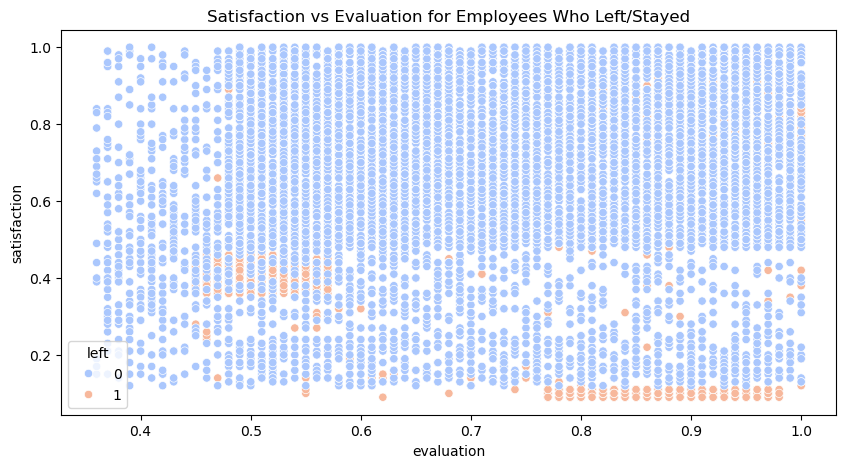

In [157]:
make_scatter(df, 'evaluation', 'satisfaction', 'Satisfaction vs Evaluation for Employees Who Left/Stayed')

For employees who stayed, the chart reveals a concentrated cluster of data points in the upper-right quadrant, suggesting a clear correlation between higher evaluation scores (above 0.5) and higher satisfaction levels (also above 0.5). In contrast, two distinct patterns emerge for employees who left:

* One group consists of individuals with high evaluation scores but low satisfaction levels, likely due to excessive workloads and involvement in too many projects. This is evident from the number of projects histogram above which shows many of these employees were contributing to as many as seven projects.
* The other group consists of employees with average evaluation scores and satisfaction levels. This warrants further investigation due to its significant size.

Next, I'll plot satisfaction against average monthly hours. I'll also include a line representing the typical monthly working hours, assuming two weeks of 52 working weeks as annual leave. This line will be set at 168 hours per month, calculated as follows:

<br>
$$
\frac{50 \text{ weeks} \times 8 \text{ hours/day} \times 5 \text{ days/week}}{12 \text{ months}} = 168 \text{ hours per month}
$$
<br>


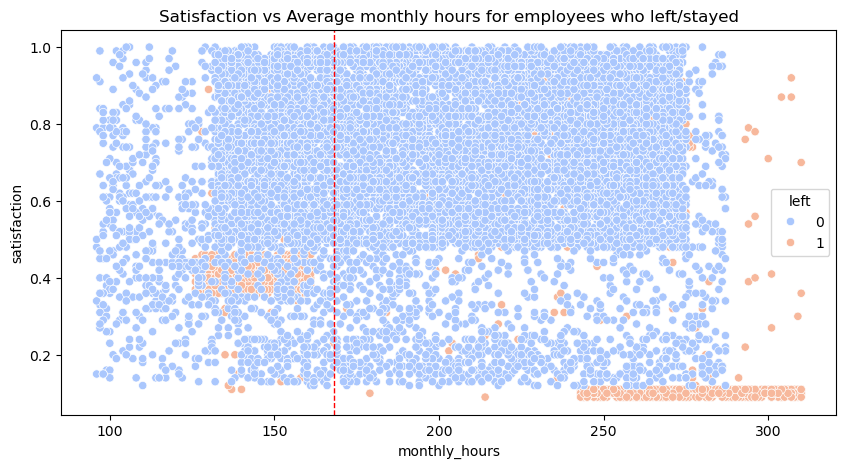

In [158]:
make_scatter(df, 'monthly_hours', 'satisfaction', 'Satisfaction vs Average monthly hours for employees who left/stayed', 168)

The plot exhibits a similar pattern to the previous one between `satisfaction` and `evaluation`, with employees who left the company falling into two distinct groups.

The first group consists of employees who worked very long hours and were dissatisfied, while the second group includes those who worked moderate hours and were moderately satisfied. Notably, the average monthly working hours for the second group are approximately 168 hours, which is the assumed standard monthly working hours.

I also noticed a threshold for monthly hours that differentiated between employees who stayed and those who left. Let's examine the maximum monthly hours for both groups to understand this distinction better:

In [159]:
df.groupby('left')['monthly_hours'].max()

left
0    287
1    310
Name: monthly_hours, dtype: int64

It is evident that none of the employees who stayed worked more than 287 hours, whereas those who left exceeded this threshold. This suggests that overworking employees could be a significant factor contributing to high turnover rates.

To explore the potential correlation between `evaluation` and `monthly_hours`, and how these factors impact employee departures, let's create a scatter plot with a regression line for employees who have left the company:

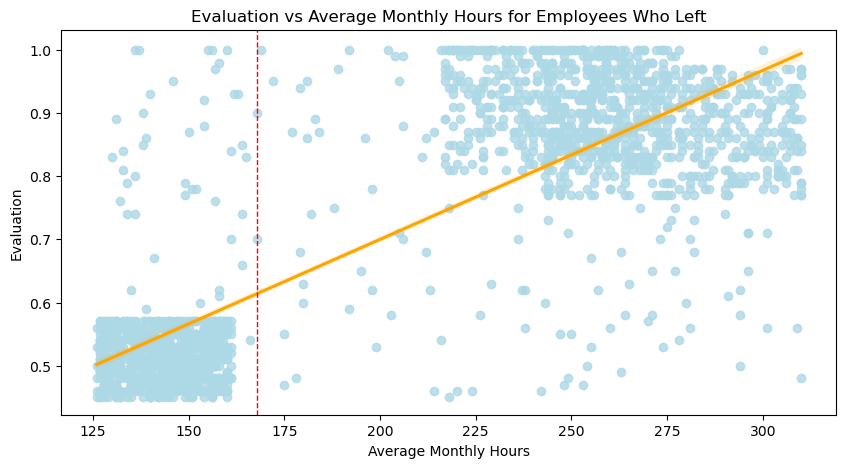

In [160]:
# Filter the dataset for only employees who left
df_left = df[df['left'] == 1]

# Set the figure size
plt.figure(figsize=(10, 5))

# Create a scatter plot between monthly hours and evaluation for employees who left
sns.regplot(data=df_left, x='monthly_hours', y='evaluation', scatter_kws={'color': 'lightblue'}, line_kws={'color': 'orange'})

# Add labels and title
plt.xlabel('Average Monthly Hours')
plt.ylabel('Evaluation')
plt.title('Evaluation vs Average Monthly Hours for Employees Who Left')

# Add a vertical dashed red line at the value 168 of normal working hours per month as an indication of the normal limit
plt.axvline(x=168, color='red', linestyle='--', linewidth=1)

plt.show()

Analyzing the plots for evaluation, satisfaction, and monthly hours reveals a noticable trend. While employees who work more hours tend to receive better evaluations, they also report lower satisfaction levels and are more likely to quit.

Overall, this suggests that overworking employees, despite leading to higher evaluations, may be a contributing factor to higher turnover rates. This finding indicates that the evaluation system might need revision to balance performance metrics with employee well-being and job satisfaction.

Next, we will investigate the relationship between satisfaction levels and the number of projects for employees who left versus those who stayed. **This analysis aims to determine whether the workload, as indicated by the number of projects, significantly affects employee satisfaction and turnover**. I will first define a function to create a bivariate violin plot (for employees who left/stayed) that visualizes the relationships between different variables in the dataset:

In [161]:
# Define a function to create a bivariate violin plot for employees who left/stayed, and different variables
def make_bivariate_violin(df, x, y, title, horizontal_line=None):
  """
  Creates a bivariate violin plot between two variables categorized by employees who left and stayed.
  Args:
    df: the dataset containing the data
    x (str): the variable on the x-axis
    y (str): the variable on the y-axis
    title (str): the title of the plot
    horizontal_line (float, optional): the value at which to draw a horizontal dashed red line. Defaults to None.
  """
  # Create a new figure with specified size
  plt.figure(figsize=(12, 5))

  # Generate the violin plot using seaborn, categorizing by 'left' and using a coolwarm color palette
  sns.violinplot(data=df, x=x, y=y, hue='left', split=True, palette='coolwarm')

  # Set the x-axis label
  plt.xlabel(x)

  # Set the y-axis label
  plt.ylabel(y)

  # Set the title of the plot
  plt.title(title)

  # If a horizontal line value is provided, add a vertical dashed red line at that value
  if horizontal_line is not None:
      plt.axhline(y=horizontal_line, color='red', linestyle='--', linewidth=1)

  # Display the plot
  plt.show()

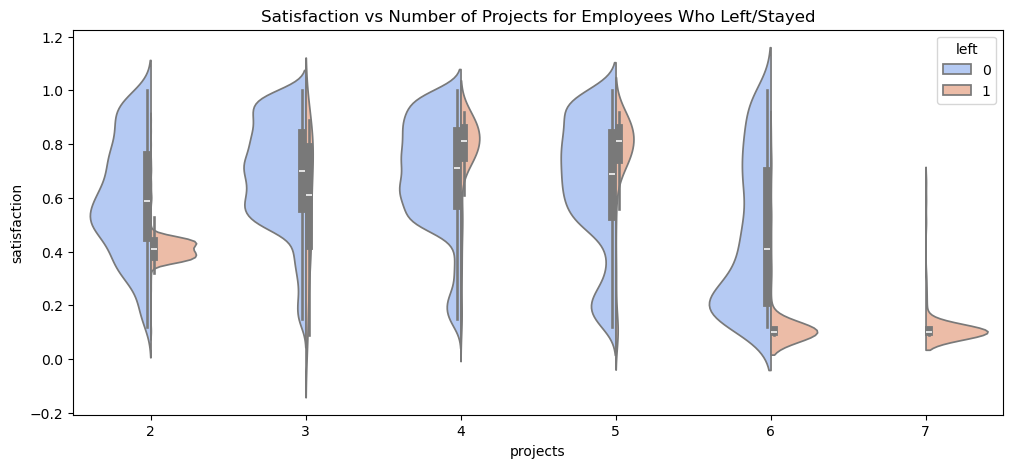

In [162]:
make_bivariate_violin(df, 'projects', 'satisfaction', 'Satisfaction vs Number of Projects for Employees Who Left/Stayed')

For employees who left, we observe that the majority had contributed to either 2 projects or 6 to 7 projects. The one who contributed to 2 projects had shown lower than average satisfaction levels, and those who worked on 6 or 7 projects, in particular, exhibited low satisfaction levels. In contrast, a smaller group of employees who left had contributed to 3 to 5 projects, and they generally reported higher satisfaction.

Additionally, the significant number of employees who contributed to two projects and subsequently left the company is an area that warrants further investigation.

Let's examine the relationship between the number of projects and the average monthly working hours for employees who have left the company versus those who have stayed:

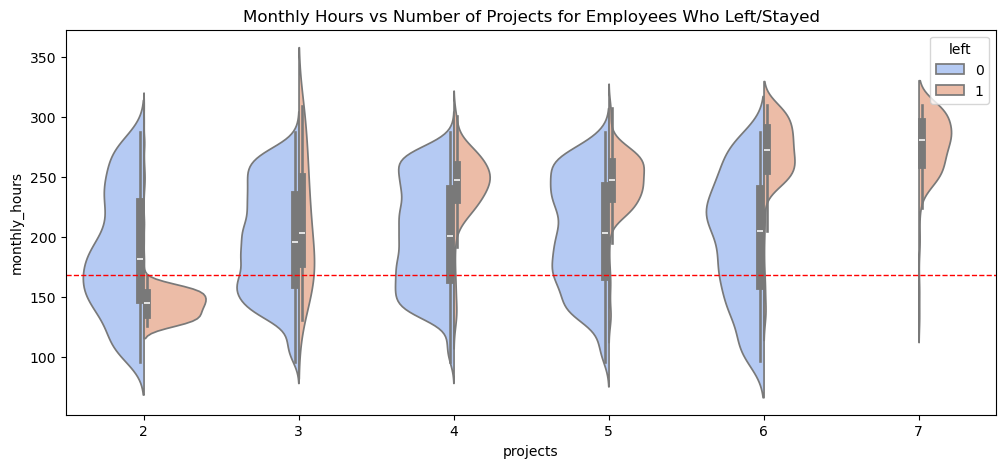

In [163]:
make_bivariate_violin(df, 'projects', 'monthly_hours', 'Monthly Hours vs Number of Projects for Employees Who Left/Stayed', 168)

Unlike employees who stayed, whose monthly working hours remained stable even as they contributed to more projects, employees who left the company showed a different pattern. For those who resigned, there was a positive correlation between the number of projects they handled and their average monthly working hours. **This suggests that employees who face increasing workloads due to additional projects are more likely to quit, as their hours rise in response. It indicates that assigning more projects and expecting employees to work longer hours to complete them is not an effective approach. Employees who stay tend to maintain consistent hours, while those who increase their hours to meet rising demands often end up feeling overworked, ultimately leading to resignation.**

Next, I will plot satisfaction against the tenure of employees who left and those who stayed to analyze the relationship between job satisfaction and employee retention.

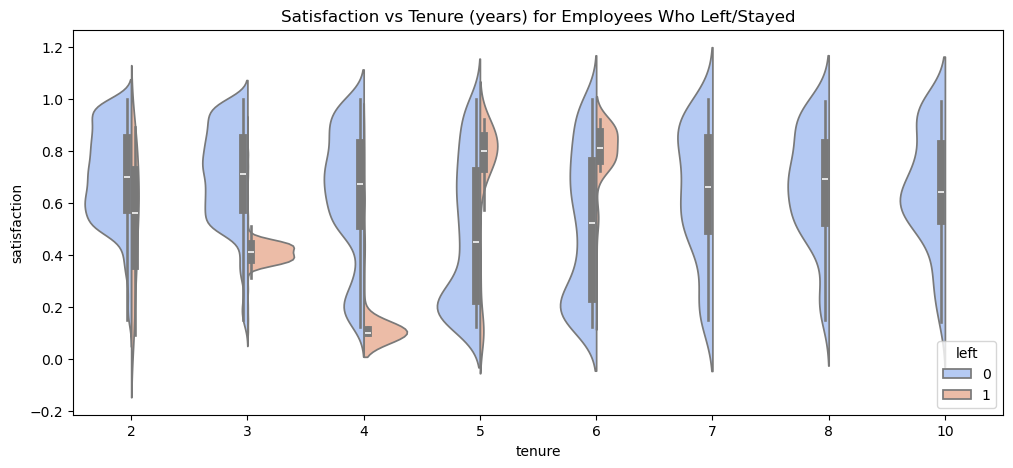

In [164]:
make_bivariate_violin(df, 'tenure', 'satisfaction', 'Satisfaction vs Tenure (years) for Employees Who Left/Stayed')

Based on the plot, several observations can be made:

* **Employees who remain with the company generally show a broader range of satisfaction**, with many indicating high levels of contentment. There is a slight decrease in satisfaction around the 5 and 6-year marks, which may warrant further investigation, but satisfaction levels tend to rise again afterward.

* Some employees who **left after 5 or 6 years reported being satisfied, suggesting they might have sought more appealing opportunities** after investing considerable time in the company.

* There is **no turnover among employees with longer tenure (6-10 years)**, indicating that those who stay longer are less likely to leave. This could be attributed to factors such as company loyalty, increasing satisfaction, or other retention incentives.

* A small number of employees who left after 2 years were likely still adjusting and uncertain about their role. **Those who departed after 3 or 4 years reported significantly lower satisfaction, with a sharp decline noted for employees leaving at the 4-year mark. This trend suggests that retention efforts should be focused on employees in their 3rd and 4th years, as dissatisfaction appears to strongly correlate with departures during this period.**

Next, I will plot job satisfaction against whether an employee has experienced an accident or not to analyze the relationship between job satisfaction and accident occurrence:

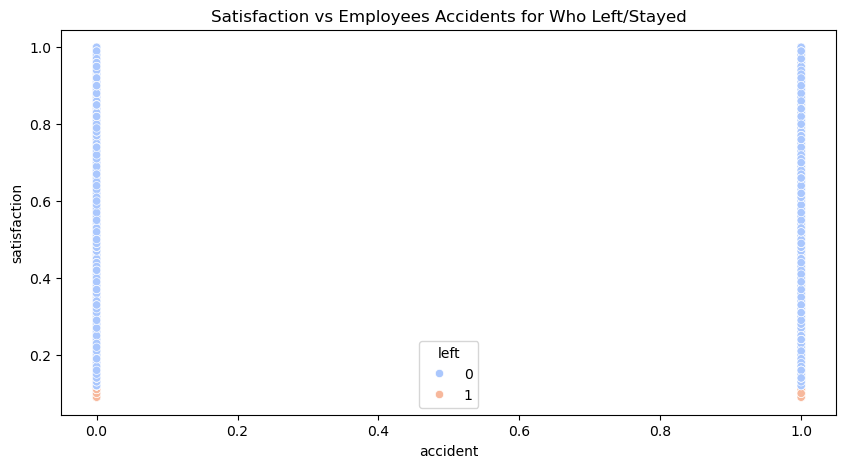

In [165]:
make_scatter(df, 'accident', 'satisfaction', 'Satisfaction vs Employees Accidents for Who Left/Stayed')

Employees who left tend to have lower satisfaction scores, regardless of whether they experienced an accident.

The occurrence of accidents doesn’t seem to strongly correlate with leaving the company, as employees who stayed (blue) show a wide range of satisfaction scores both with and without accidents.

There appears to be **no correlation between employee turnover and the occurrence of accidents while at the company.**

Next, I will plot job satisfaction against whether an employee has received a promotion in the last 5 years or not to analyze the relationship between promotions and job satisfaction.

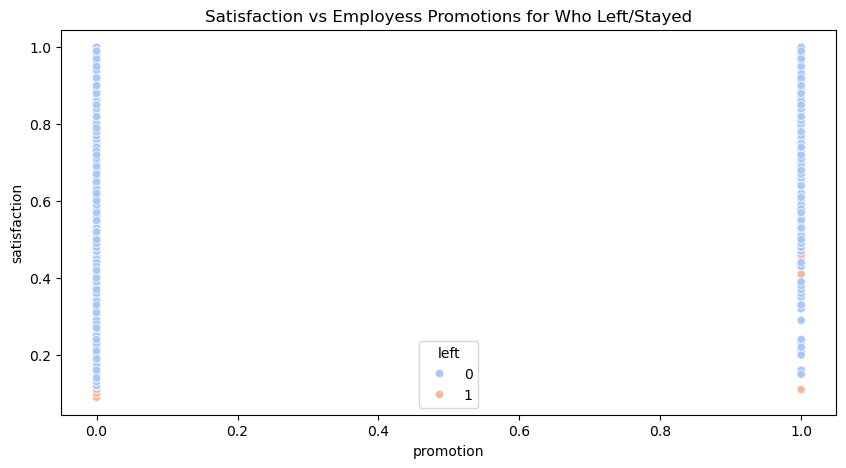

In [166]:
make_scatter(df, 'promotion', 'satisfaction', 'Satisfaction vs Employess Promotions for Who Left/Stayed')

**Promotions appeared to have minimal impact on employee turnover**. Regardless of whether they received a promotion or not, employee satisfaction seemed to be the primary factor influencing their decision to leave.

Notably, a small number of employees who had been promoted within the last five years still chose to leave the company. This could suggest that these individuals were seeking better opportunities elsewhere, despite being generally satisfied with their current role.

Next, I will plot the satisfaction rates for each department and for each salary level, comparing those who left with those who stayed:

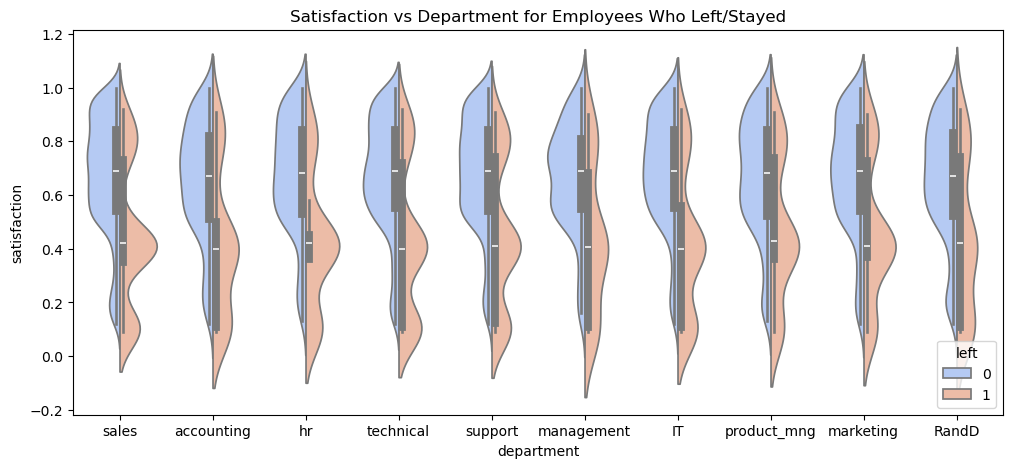

In [167]:
make_bivariate_violin(df, 'department', 'satisfaction', 'Satisfaction vs Department for Employees Who Left/Stayed')

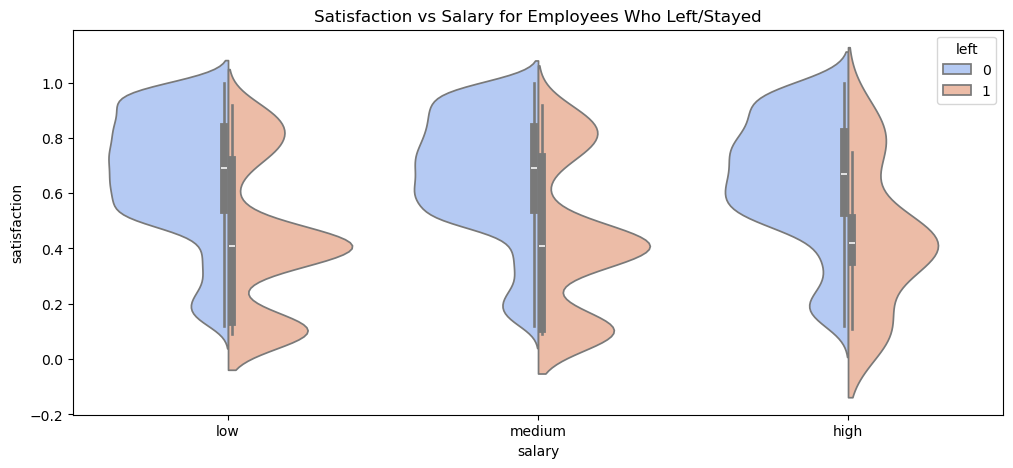

In [168]:
make_bivariate_violin(df, 'salary', 'satisfaction', 'Satisfaction vs Salary for Employees Who Left/Stayed')

Across all departments and salary ranges, employee turnover patterns appear consistent: regardless of department or compensation, dissatisfied employees are likely to leave.

Next, let's examine the relationship between employee evaluations and the number of projects they contributed to, in order to understand how project involvement impacts performance assessments and employee turnover.

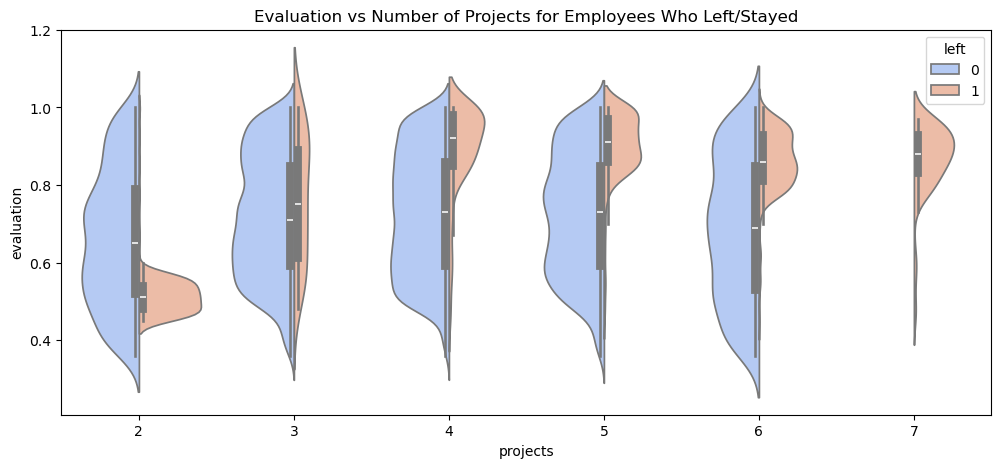

In [169]:
make_bivariate_violin(df, 'projects', 'evaluation', 'Evaluation vs Number of Projects for Employees Who Left/Stayed')

Employee turnover and project involvement exhibit notable patterns:

* As seen before, it seems that the more projects you contribute to, the higher the evaluation.

* Employees who worked on three or more projects before leaving received higher evaluations than those who stayed after completing the same number of projects. This suggests that while these employees made significant contributions, they may have felt overworked or underappreciated, ultimately leading to their departure.
* Conversely, employees who worked on only two projects tended to receive lower evaluations upon leaving, with their ratings falling below those who remained with the company.
* No employee who contributed to seven projects chose to stay, further emphasizing a correlation between the number of projects and turnover.

These trends indicate a need to review and potentially adjust the evaluation system, as it appears ineffective in retaining high-performing employees.

Next, let us examine the relationship between employee evaluations and their tenure:

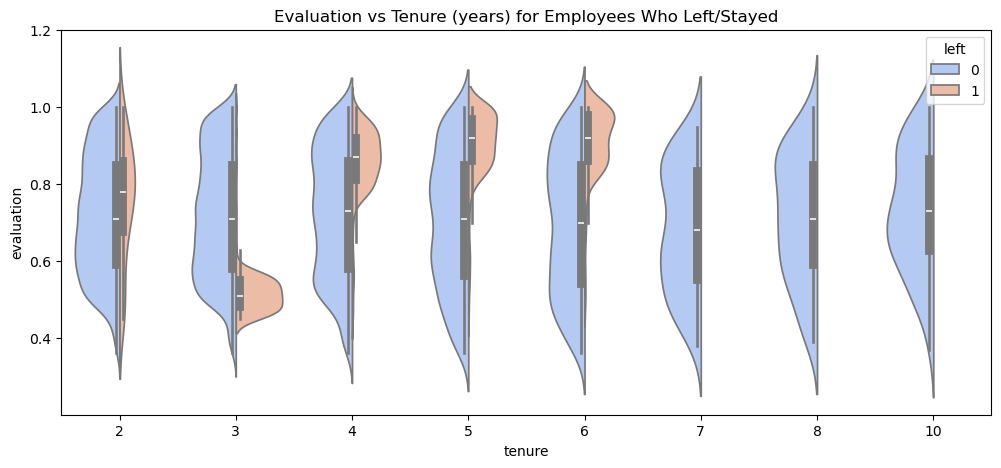

In [170]:
make_bivariate_violin(df, 'tenure', 'evaluation', 'Evaluation vs Tenure (years) for Employees Who Left/Stayed')

Evaluation scores for employees who stayed were relatively consistent across all tenure lengths. However, there is a noticeable dip in evaluations for those who left at the three-year mark. This calls for further investigation, as there may be specific factors or events around the three-year point influencing employees’ decisions to leave. It’s possible that employees feel their contributions are undervalued, or they experience a lack of growth opportunities during this time.

Interestingly, after the three-year mark, employees who left generally received higher evaluations than those who stayed. However, none of the employees who left remained with the company for more than six years.

Next, we will plot the performance evaluations for each department and for each salary level, comparing the evaluations of employees who left the company with those who stayed. This analysis will help us understand how departmental and salary factors influence employee retention and performance:

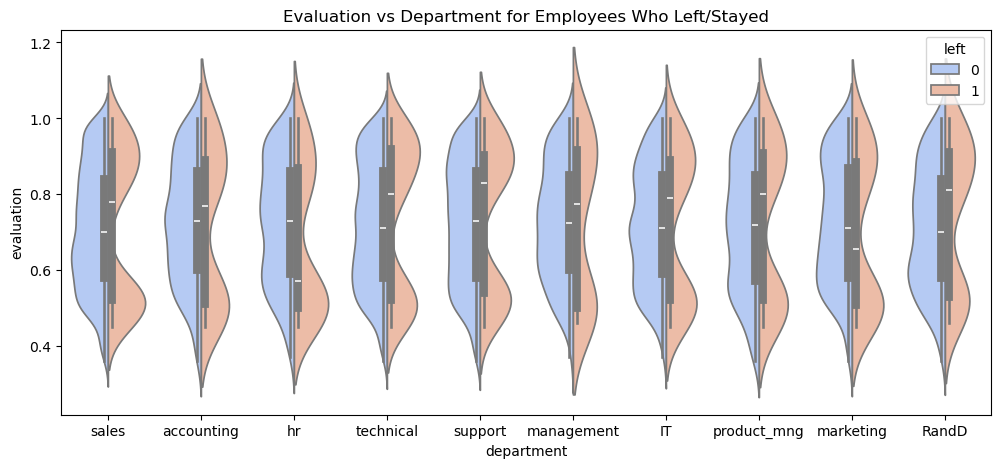

In [171]:
make_bivariate_violin(df, 'department', 'evaluation', 'Evaluation vs Department for Employees Who Left/Stayed')

Overall, the **departments appear quite similar in terms of evaluation patterns**. However, there is a notable exception: in the Marketing and HR departments, employees who left had lower evaluation scores compared to their peers who stayed. This discrepancy may require a more in-depth investigation specific to these departments.

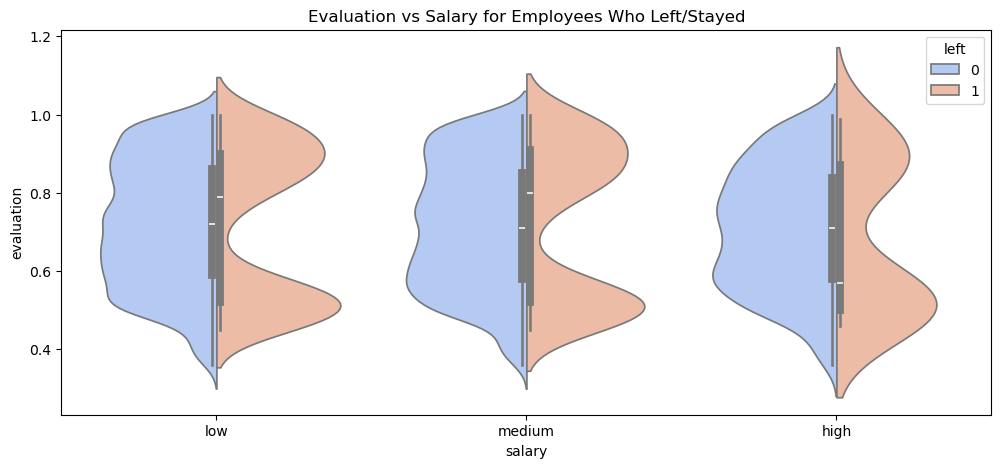

In [172]:
make_bivariate_violin(df, 'salary', 'evaluation', 'Evaluation vs Salary for Employees Who Left/Stayed')

Comparing salary ranges, employees who **left and those who stayed show similar distributions in the low and medium brackets**, with departing employees generally receiving slightly higher evaluations than their staying peers. However, in the **higher salary ranges, employees who left had lower evaluation scores than those who remained**.

Now let's plot projects agianst tenure:

In [173]:
def make_barplot_per_left(df, x, y, title):
    """
    The function generates a bar plot where the bars are differentiated by the 'left' column

    Parameters:
    df (DataFrame): The pandas DataFrame containing the data to be plotted.
    x (str): The column name to be used for the x-axis.
    y (str): The column name to be used for the y-axis.
    title (str): The title of the plot.

    """

    # Set figure size for the plot
    plt.figure(figsize=(12, 5))

    # Create a bar plot with seaborn, colored by the 'left' column
    sns.barplot(data=df, y=y, x=x, hue='left', palette='coolwarm')

    # Labeling the axes
    plt.ylabel(x)  # Label the y-axis
    plt.xlabel(y)  # Label the x-axis

    # Adding a title to the plot
    plt.title(title)

    # Set background color to white
    plt.gcf().set_facecolor('white')

    # Show the plot
    plt.show()

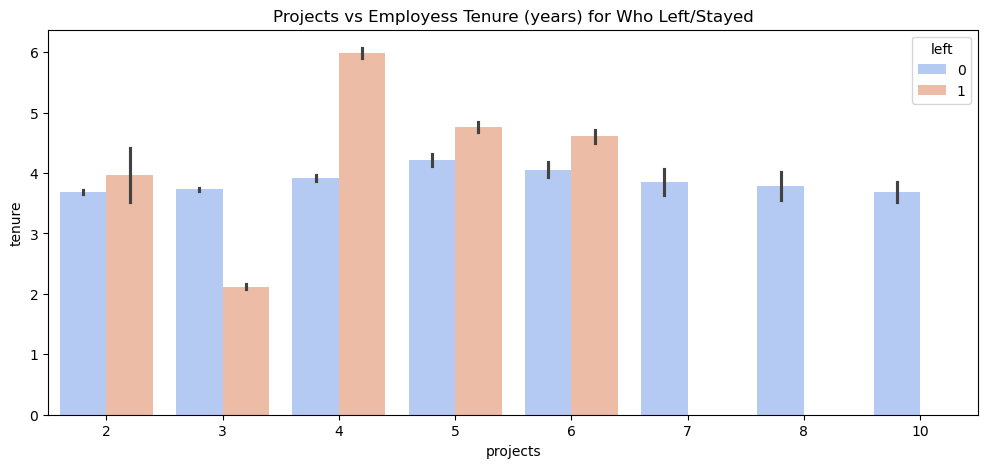

In [174]:
make_barplot_per_left(df, 'tenure', 'projects', 'Projects vs Employess Tenure (years) for Who Left/Stayed')

I can see that **employees who left contributed to more projects than their peers who stayed till the 6 years mark, except for the 3 years mark (in which they also had significantly lower evaluations too), this suggests a potential disengagement or performance issue at this stage**. It’s possible these employees were not being assigned to enough meaningful or challenging projects, which may have contributed to their decline in performance and eventual departure.

**I also can notice that in the 4 years mark, employees who left had a significant uptick in the number of projects they contributed to, this peak in project workload could reflect the company’s efforts to retain high performers by giving them more tasks, but without providing adequate support or recognition, leading to frustration and, ultimately, attrition.**

Next, we will plot the number of projects employees contributed to against each department and salary level, comparing employees who left the company with those who stayed. This analysis will help us understand how project involvement varies across departments and salary levels for both groups:

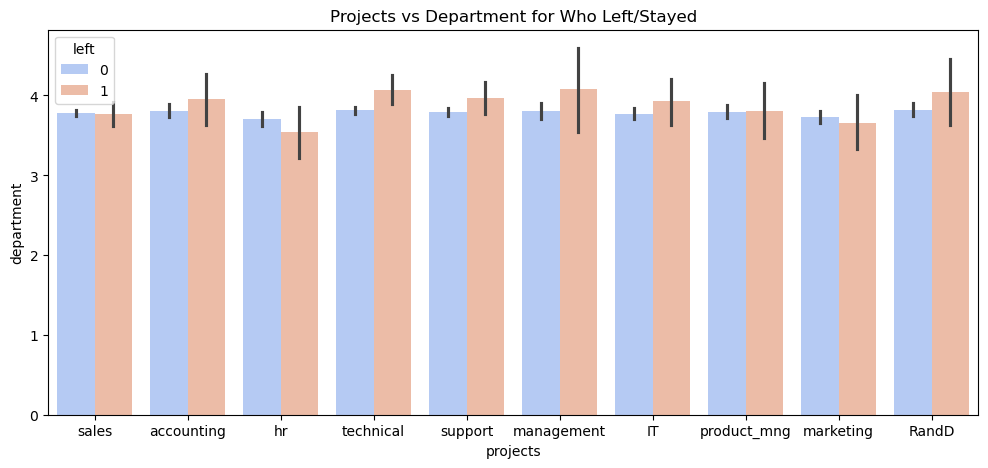

In [175]:
make_barplot_per_left(df, 'department', 'projects', 'Projects vs Department for Who Left/Stayed')

Across departments, **the number of projects employees contributed to is generally consistent, with those who left having worked on slightly more projects**. However, similar to evaluation patterns, the Marketing and HR departments are exceptions, where employees who left had worked on slightly fewer projects than those who stayed.

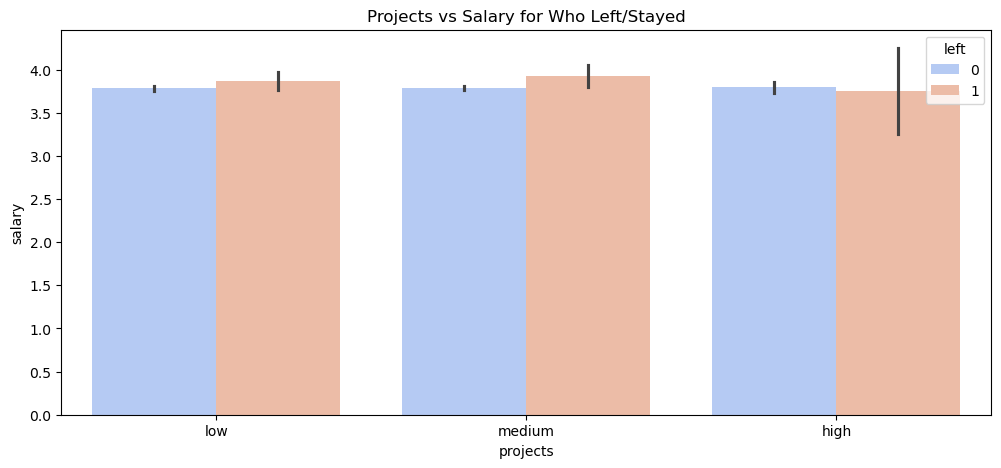

In [176]:
make_barplot_per_left(df, 'salary', 'projects', 'Projects vs Salary for Who Left/Stayed')

Across low and medium salary ranges, **employees who left and those who stayed had similar compensation, with departing employees contributing to slightly more projects. Conversely, in the higher salary ranges, employees who stayed contributed to more projects than those who left.**

Now let's plot the employee average monthly hours againts their tenure at the company:

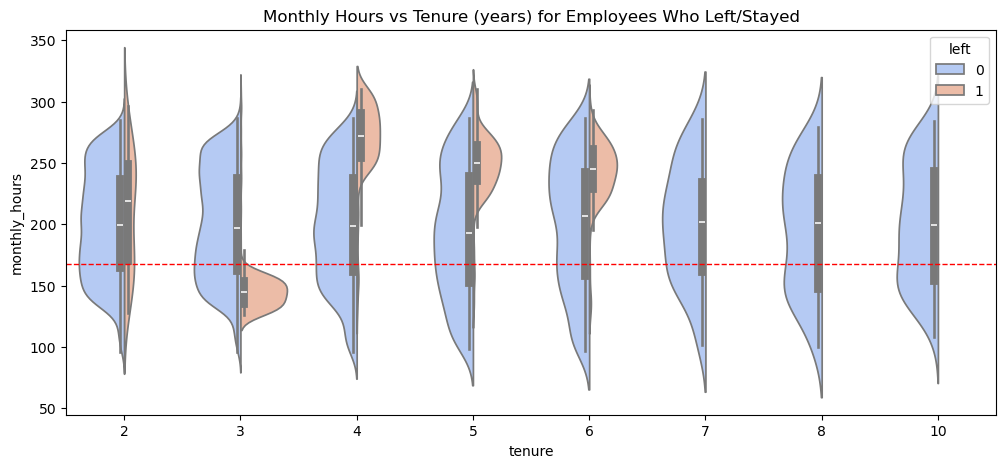

In [177]:
make_bivariate_violin(df, 'tenure', 'monthly_hours', 'Monthly Hours vs Tenure (years) for Employees Who Left/Stayed', 168)

Across all tenure years, the trend is consistent for employees who stayed. However, for those who left, the pattern mirrors their evaluation trend, with **monthly worked hours dipping significantly at the 3-year mark**. This suggests either a specific factor or event occurring at this point or that employees may feel stagnant in their roles without opportunities for growth at this particular stage.

### **Insights:**

1. **Job Satisfaction**: Employees who left the company generally had lower job satisfaction, particularly those with satisfaction levels below 0.5. However, some who stayed were dissatisfied, indicating dissatisfaction is a key but not sole factor in turnover.
2. **Performance Evaluations**: Turnover occurred among both high and low performers, while average performers were more likely to stay. High evaluations paired with low satisfaction suggested overworked top talent, potentially leading to their departure.
3. **Workload and Projects**: Employees who contributed to 6 or more projects were significantly more likely to leave, indicating that overwork could be a contributing factor. Those who worked on fewer than 3 projects also exhibited high turnover, suggesting disengagement. An optimal workload of 3-5 projects correlated with retention.
4. **Monthly Hours**: Extreme working hours, either very high (above 287 hours) or very low, were associated with higher turnover rates. Employees working a balanced range of 150-260 hours per month were more likely to remain, highlighting a need to manage workload and avoid burnout.
5. **Tenure**: The highest turnover was observed around the 3-year mark, with both low satisfaction and evaluations contributing to attrition. Employees who remained beyond 6 years showed very low turnover rates, indicating greater job stability and loyalty among long-tenured staff.
6. **Accidents**: Accident rates were slightly higher among employees who left (17%) compared to those who stayed (5%), though this factor did not strongly correlate with turnover.
7. **Promotions**: Lack of promotion had minimal impact on turnover, as 99% of both stayers and leavers had not been promoted in the past five years. This suggests promotions were not a key factor influencing employee retention.
8. **Department & Salary**: No specific department exhibited disproportionately high turnover, though turnover was slightly higher among sales due to larger workforce numbers. Higher-paid employees showed lower turnover, while the difference between low and medium salary ranges was not significant.
9. **Workload and Evaluations**: Employees working more hours and contributing to more projects tended to receive higher evaluations but reported lower satisfaction, suggesting overwork leads to disengagement despite strong performance.
10. **Retention Strategy Focus**: Retention efforts should focus on employees at the 3-4 year mark and those handling excessive project loads, as these groups exhibit the highest turnover risks.

**By addressing workload balance, managing satisfaction, and re-evaluating the performance and evaluation system, the company can better retain high-performing employees and reduce turnover.**

# paCe: Construct Stage


Given that the outcome variable y is a categorical variable with values of 0 and 1, I will first construct a binomial logistic regression model.

## **Data Modeling Preparation**

From my EDA, I can remove the outliers fro the variable `tenure`. I'll also encode the `salary` column in ordinal order, and dummy encode the `department` column.

In [178]:
# since I'll be constructing a logistic regression model, I'll remove the extreme outliers from my dataset
df_model = df[df['tenure'] < 5.5]

# encode salary column
salary_dict = {'low': 0, 'medium': 1, 'high': 2}
df_model['salary'] = df_model['salary'].replace(salary_dict)

# dummy encode department column
department_encoded = pd.get_dummies(df_model['department'], dtype=int, drop_first=True)
df_model = df_model.drop(columns='department')
df_model = pd.concat([df_model, department_encoded], axis=1)

# View the dataset
df_model

/var/folders/zn/b35vzv6n4vz4fq795kwwhxs40000gn/T/ipykernel_20780/3176474510.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['salary'] = df_model['salary'].replace(salary_dict)


satisfaction  evaluation  projects  monthly_hours  tenure  accident  \
0              0.38        0.53         2            157       3         0   
2              0.11        0.88         7            272       4         0   
3              0.72        0.87         5            223       5         0   
4              0.37        0.52         2            159       3         0   
5              0.41        0.50         2            153       3         0   
...             ...         ...       ...            ...     ...       ...   
11985          0.72        0.64         4            192       3         0   
11986          0.48        0.50         5            142       4         0   
11987          0.19        0.79         4            229       4         0   
11992          0.62        0.85         3            237       3         1   
11999          0.50        0.73         4            180       3         0   

       left  promotion  salary  RandD  accounting  hr  management  marketing  \
0         1          0       0      0           0   0           0          0   
2         1          0       1      0           0   0           0          0   
3         1          0       0      0           0   0           0          0   
4         1          0       0      0           0   0           0          0   
5         1          0       0      0           0   0           0          0   
...     ...        ...     ...    ...         ...  ..         ...        ...   
11985     0          0       1      0           0   0           0          0   
11986     0          0       1      0           0   0           0          0   
11987     0          0       1      0           0   0           0          0   
11992     0          0       1      0           0   0           0          0   
11999     0          0       0      0           0   0           0          0   

       product_mng  sales  support  technical  
0                0      1        0          0  
2                0      1        0          0  
3                0      1        0          0  
4                0      1        0          0  
5                0      1        0          0  
...            ...    ...      ...        ...  
11985            0      1        0          0  
11986            0      0        0          0  
11987            1      0        0          0  
11992            0      0        0          0  
11999            0      0        0          0  

[11167 rows x 18 columns]

In [179]:
# Save X and y data into variables
X = df_model.drop('left', axis=1)
y = df_model[['left']]

In [180]:
# Split into training + temp set (validation and testing sets)
X_tr, X_temp, y_tr, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

Given the dataset is large enough, I will partition it into three subsets to streamline the model training and evaluation process: a **training set, a validation set, and a test set**. The training set will comprise the majority of the data (70% of the dataset) and will be utilized to train the model, conduct cross-validations if necessary, and fine-tune hyperparameters to optimize performance. The validation set will be used during the training phase to assess the model's metrics and subsequently select the best-performing model (15% of the dataset). Finally, the test set will be reserved until after the best model is chosen, providing an unbiased evaluation of its performance on unseen data (15% of the dataset).

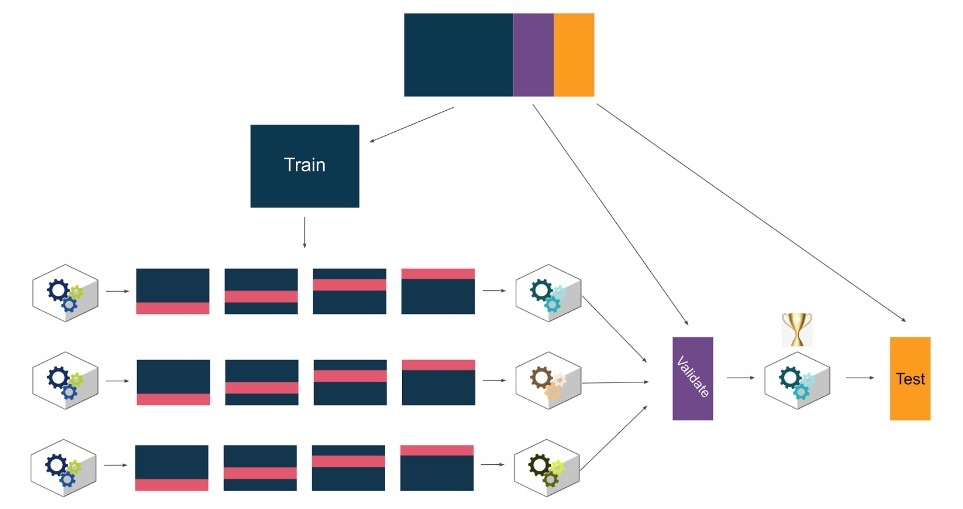

In [181]:
# Split the temp set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Some variables in our dataset have very different minimum and maximum values, for example, `satisfaction` and `evaluation` have small values from 0 to 1, compared to `monthly_hours` which goes up to 310. So I’ll use MinMaxScaler to scale the data. This ensures features are on a similar range, preventing larger features from dominating the model and improving model performance

In [182]:
# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the training data
scaler.fit(X_tr)

# Scale the training data and convert back to DataFrame in order to use properly when checking logistic regression assumptions
X_tr = pd.DataFrame(scaler.transform(X_tr), columns=X_tr.columns)

# Scale the validation data data and convert back to DataFrame
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)

# Scale the testing data data and convert back to DataFrame
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

## **Logistic Regression Model**

It's best to check logistic regression assumptions both before and after fitting the model.

Before fitting the model:
1. **Independence of observations**: This is typically ensured by the study design and cannot be tested statistically.
2. **Sample size adequacy**: There should be a sufficient number of events per predictor.
3. **Multicollinearity**: The independent variables should not be highly correlated with each other.

After fitting the model:
4. **Linearity**: The relationship between the independent variables and the log-odds of the outcome should be linear.
5. **Outliers**: There should be no influential outliers that significantly affect the model.

In [183]:
# Checking assumptions before fitting the model
print("Checking assumptions before fitting the model:")

# 1. Independence of observations
print("\n1. Independence of observations:")
print("This assumption is typically ensured by the study design and cannot be tested statistically.")

# 2. Sample size adequacy
print("\n2. Checking sample size adequacy...")
if isinstance(y_tr, pd.DataFrame) or isinstance(y_tr, pd.Series):
    y_tr = y_tr.values
events = min(np.sum(y_tr), len(y_tr) - np.sum(y_tr))
predictors = X_tr.shape[1]
epp = events / predictors
print(f"Events per predictor: {epp:.2f}")
if epp < 10:
    print("Warning: The sample size might be too small for the number of predictors.")

# 3. Multicollinearity check
print("\n3. Checking for multicollinearity...")
vif_data = pd.DataFrame()
vif_data["Variable"] = X_tr.columns
vif_data["VIF"] = [variance_inflation_factor(X_tr.values, i) for i in range(X_tr.shape[1])]
print(vif_data)

Checking assumptions before fitting the model:

1. Independence of observations:
This assumption is typically ensured by the study design and cannot be tested statistically.

2. Checking sample size adequacy...
Events per predictor: 76.06

3. Checking for multicollinearity...
         Variable       VIF
0    satisfaction  5.274722
1      evaluation  6.114088
2        projects  4.170631
3   monthly_hours  6.209075
4          tenure  2.690855
5        accident  1.179374
6       promotion  1.029127
7          salary  1.855819
8           RandD  1.404161
9      accounting  1.352646
10             hr  1.322504
11     management  1.238345
12      marketing  1.387008
13    product_mng  1.393811
14          sales  2.781322
15        support  2.073418
16      technical  2.312855


1. **Independence of observations**: observations are assumed to be independent, as the probability of observing each data point is independent from one another. Also The data was not collected overtime, so no time effect on the data collected (company performance or economic conditions have changed during some period). So the assumption is **accepted**.
2. **Sample size adequacy**: 76.06 event per predictor is higher than the minimum threshold of 10-20, so the assumption is **accepted**.
3. **Multicollinearity check**: No variables has a VIF more than the accepted values of 10 (which suggests high multicollinearity). So the assumption is **accepted**.

In [184]:
# fit the model
clf = LogisticRegression().fit(X_tr,y_tr)

/opt/miniconda3/envs/minimal_ds/lib/python3.12/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [185]:
# Print the coefficient
print("Model coefficients:")
for feature, coef in zip(X.columns, clf.coef_[0]):
    print(f"{feature}: {coef:.4f}")

Model coefficients:
satisfaction: -4.0543
evaluation: -0.0928
projects: -2.2309
monthly_hours: 0.7404
tenure: 3.0771
accident: -1.5304
promotion: -0.6484
salary: -1.0940
RandD: -0.3849
accounting: -0.0082
hr: 0.1021
management: -0.0378
marketing: 0.0383
product_mng: -0.0653
sales: 0.2055
support: 0.0119
technical: 0.1084


In [186]:
# Print the intercept
print(f"Intercept: {clf.intercept_[0]:.4f}")

Intercept: -0.1238


Now let's continue checking the rest of the model assumptions:


Checking assumptions after fitting the model:

1. Testing linearity assumption...


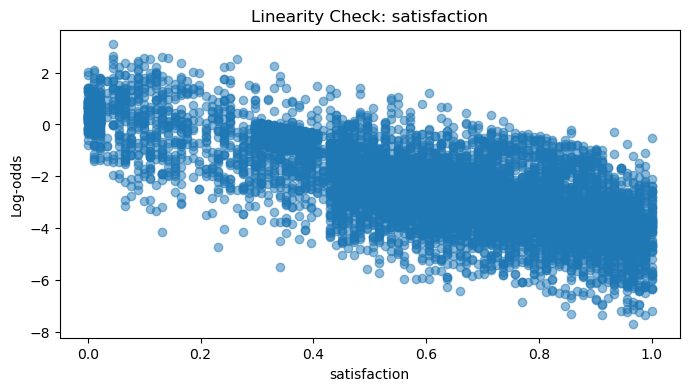

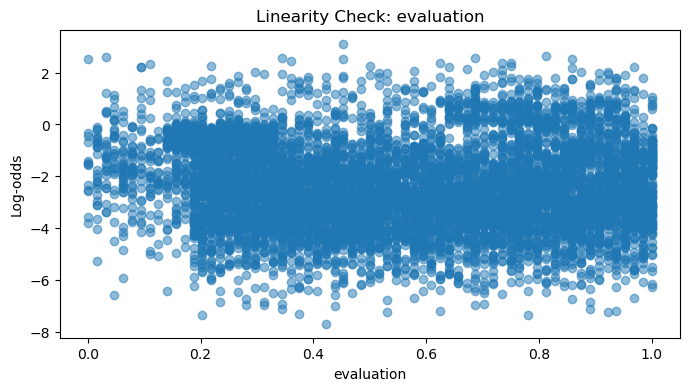

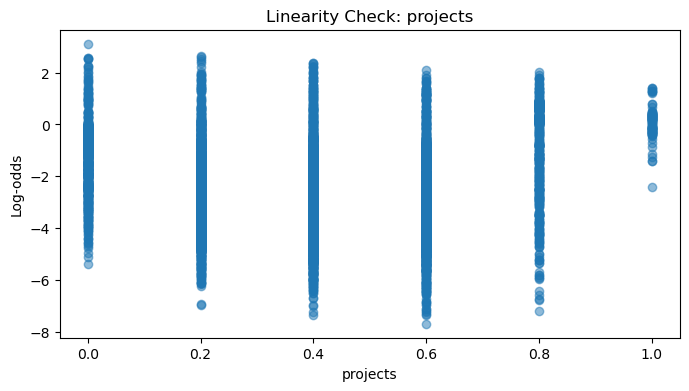

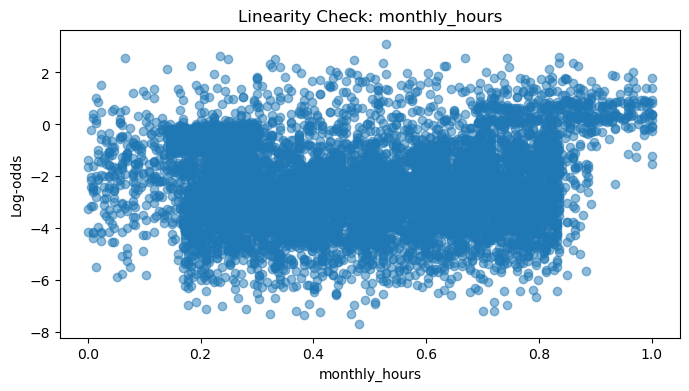

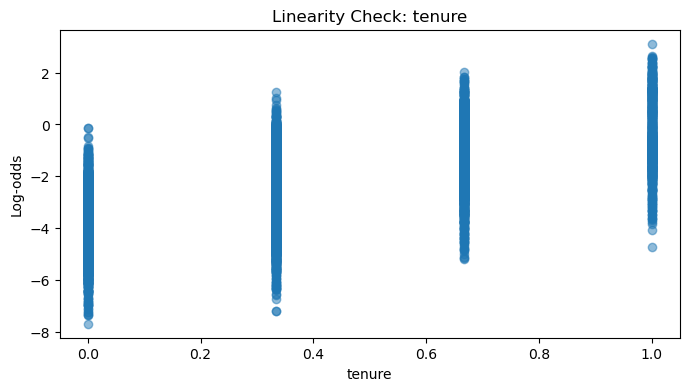

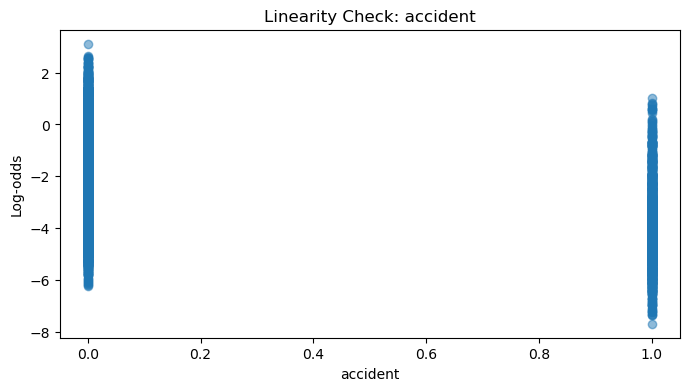

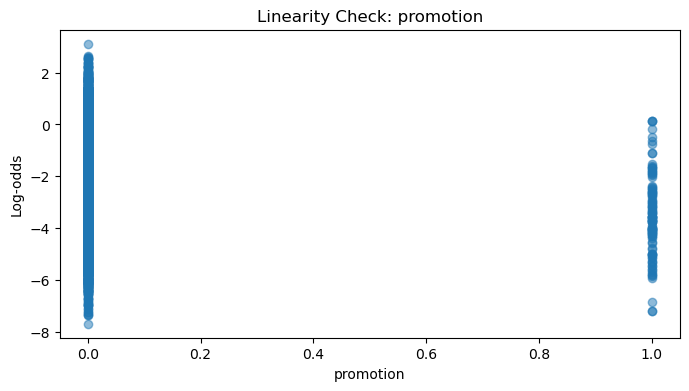

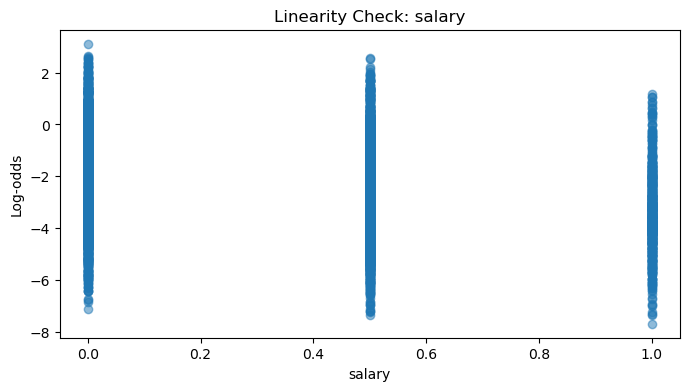

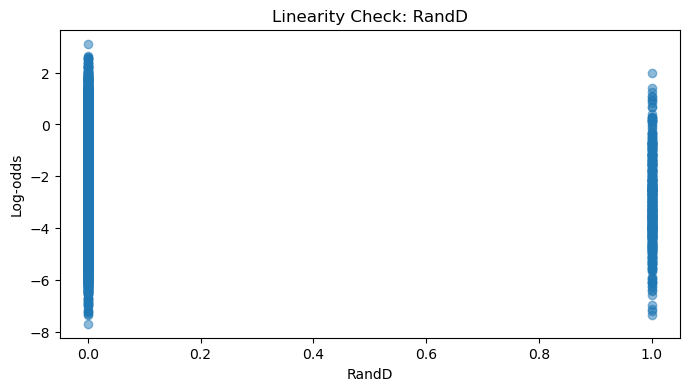

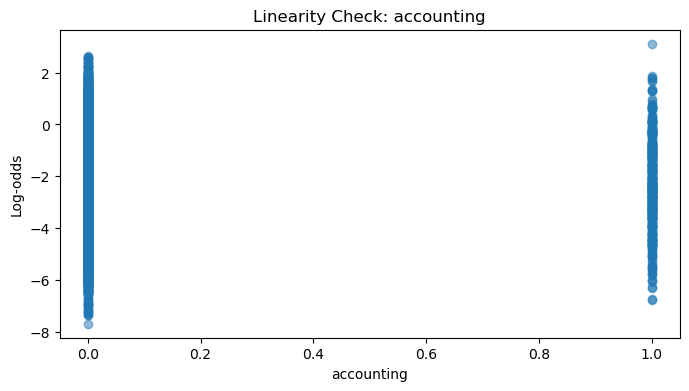

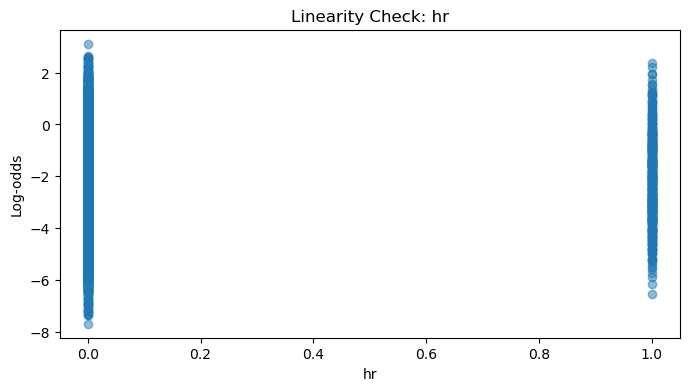

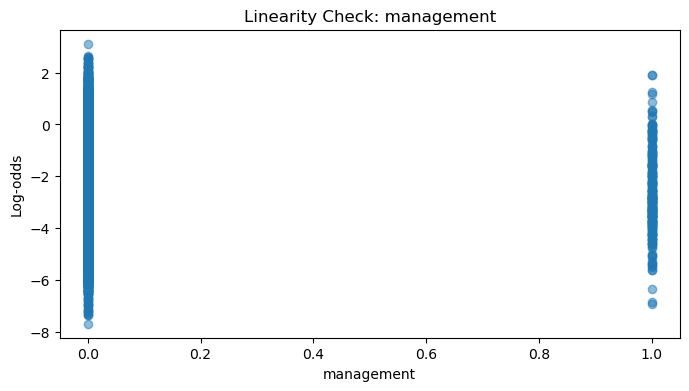

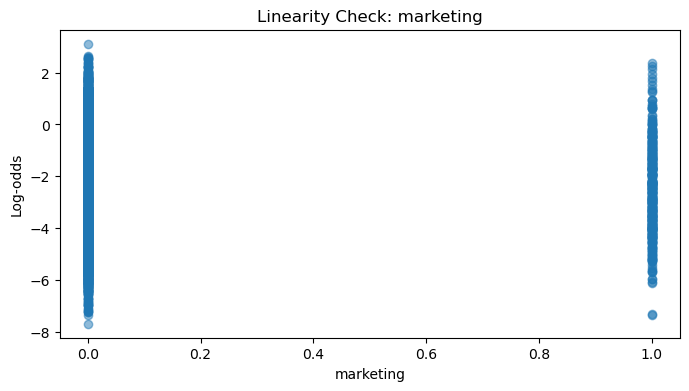

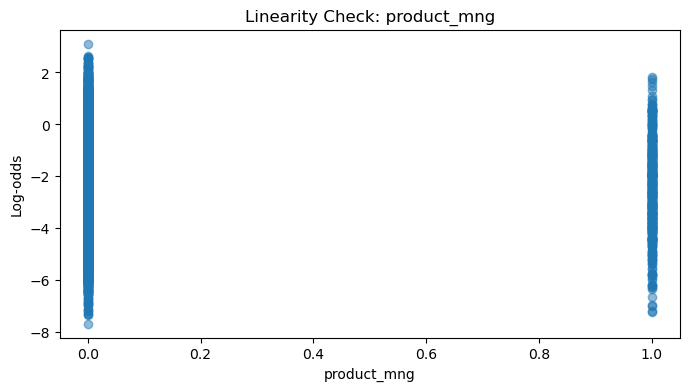

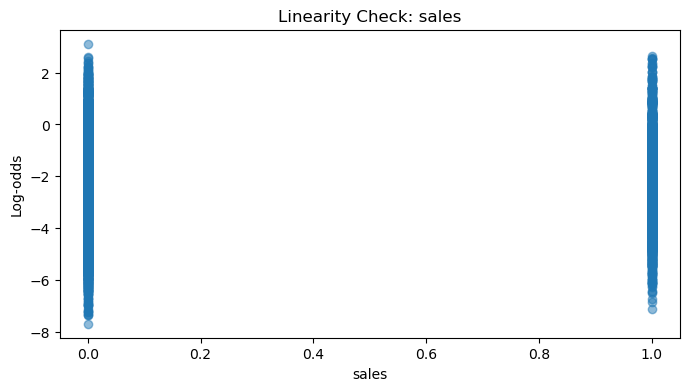

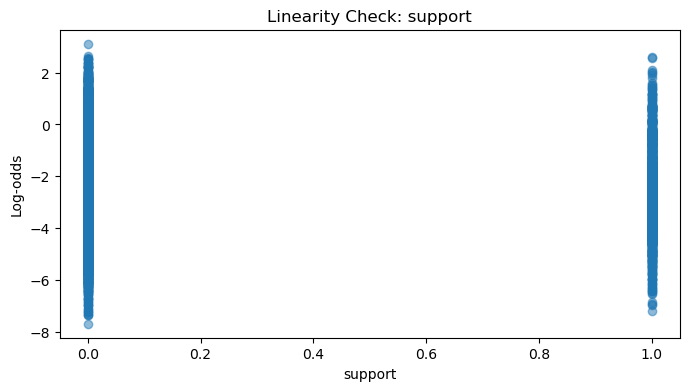

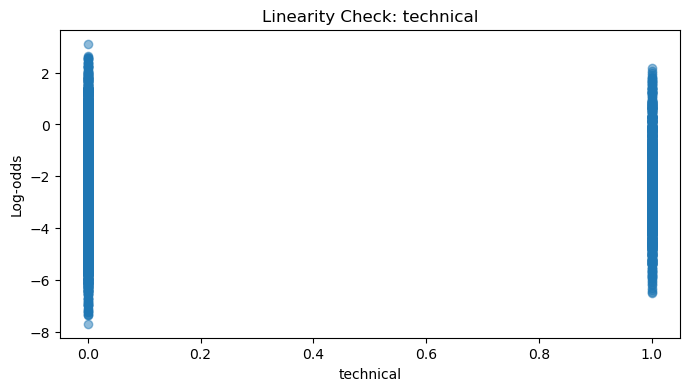


2. Checking for influential observations...


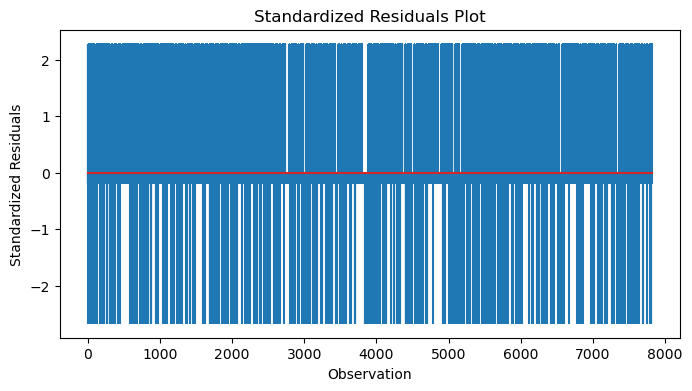

In [187]:
# Checking assumptions after fitting the model
print("\nChecking assumptions after fitting the model:")

# 4. Linearity assumption
print("\n1. Testing linearity assumption...")
log_odds = clf.decision_function(X_tr)

for i, column in enumerate(X_tr.columns):
    plt.figure(figsize=(8, 4))
    # Use .iloc[] for integer-based indexing in pandas
    plt.scatter(X_tr.iloc[:, i], log_odds, alpha=0.5)
    plt.xlabel(f'{column}')
    plt.ylabel('Log-odds')
    plt.title(f'Linearity Check: {column}')
    plt.show()

# 5. Check for influential observations
print("\n2. Checking for influential observations...")
# We'll use standardized residuals as a proxy for influence
y_pred = clf.predict(X_tr)

# Ensure y_tr and y_pred have compatible shapes for subtraction
residuals = y_tr - y_pred.reshape(y_tr.shape)
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

plt.figure(figsize=(8, 4))
plt.stem(range(len(std_residuals)), std_residuals, markerfmt=",")
plt.xlabel('Observation')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals Plot')
plt.show()

4. **Linearity assumption**: Even though the relationship between the `satisfaction` variable and the log of odds is linear, all the rest of the variables are not linear. So we **can't accept this assumption.**
5. **Check for influential observations**: Most of the standardized residuals are within a band around 0, creating a dense central band. Although the plot does indicate the presence of some outliers, specifically the points with standardized residuals that fall below -2. These outliers can have a disproportionate influence on the model’s parameters. So the assumption is **not accepted.**

Even though some of the assumptions were not accepted, I'll still check the model's performance:

In [188]:
# Save predictions
y_log_pred = clf.predict(X_val)

- Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1388
           1       0.50      0.29      0.37       287

    accuracy                           0.83      1675
   macro avg       0.68      0.61      0.63      1675
weighted avg       0.80      0.83      0.81      1675

- Model Metrics:
Model Accuracy: 82.81 %
Model Precision: 49.7 %
Model Recall: 28.92 %
Model F1 Score: 36.56 %


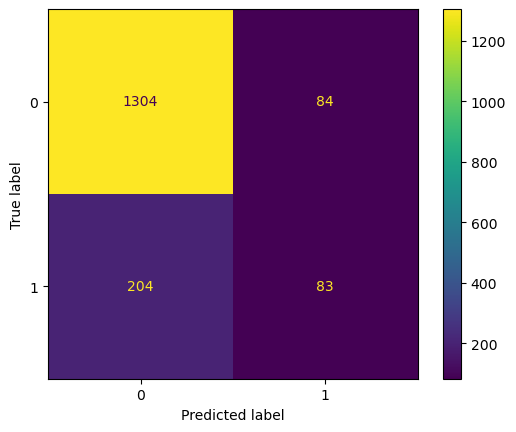

In [189]:
# Print Classification Report
print("- Classification Report:")
print(classification_report(y_val, y_log_pred))

# Print Model Metrics
print("- Model Metrics:")
print('Model Accuracy:', round((accuracy_score(y_val,y_log_pred)*100), 2), '%')
print('Model Precision:', round((precision_score(y_val,y_log_pred)*100), 2), '%')
print('Model Recall:', round((recall_score(y_val,y_log_pred)*100), 2), '%')
print('Model F1 Score:', round((f1_score(y_val,y_log_pred)*100), 2), '%')

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y_val, y_log_pred, labels = clf.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf.classes_)

# Display the confusion matrix
disp.plot(values_format='');


ROC AUC: 0.8846


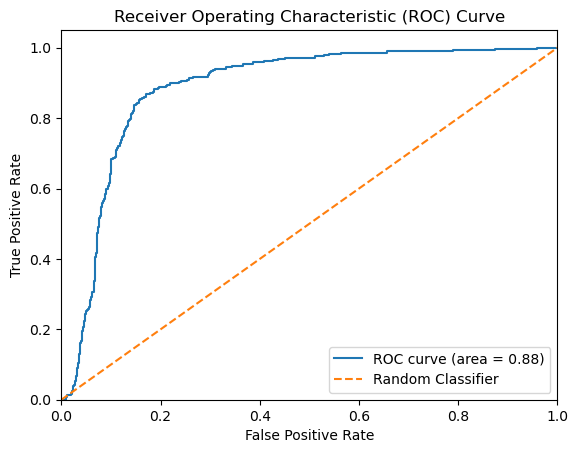

In [190]:
# Predict probabilities for the positive class (class 1) on the validation set
y_log_pred_proba = clf.predict_proba(X_val)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_log_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

In [191]:
# Create table of results
log_results_table = pd.DataFrame()
# Create table of results
log_results_table = pd.DataFrame({'Model': 'Logistic Regression Model',
                      'F1': [f1_score(y_val,y_log_pred)],
                      'Recall': [recall_score(y_val,y_log_pred)],
                      'Precision': [precision_score(y_val,y_log_pred)],
                      'Accuracy': [accuracy_score(y_val,y_log_pred)]
                      }
                    )

# View the results table
log_results_table

Model        F1    Recall  Precision  Accuracy
0  Logistic Regression Model  0.365639  0.289199   0.497006   0.82806

While the logistic regression model demonstrated **reasonable performance in the accuracy score, its recall, precision and F1-score were significantly lower and not to be relied on**.


I'll check the class balance to see if the class imbalance is the reason why the metrics are so low.

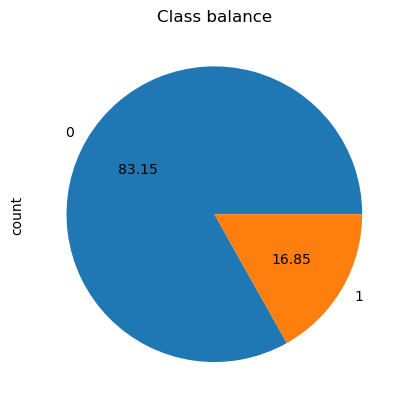

In [192]:
# Plot a pie chart to show the class balance of the 'left' column in the dataframe
df_model['left'].value_counts().plot.pie(autopct='%.2f').set_title("Class balance");

From the above pie chart, I can see that the class balance is accepted, but I'll oversample the 1 value of the `left` column and reconstruct the model to see if this would wield better results.

In [193]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


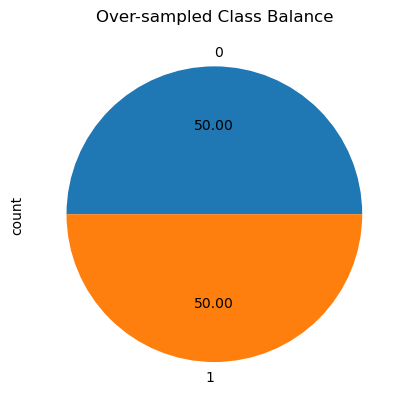

In [194]:
# Import the RandomOverSampler from imblearn
from imblearn.over_sampling import RandomOverSampler

# Create an instance of RandomOverSampler with a sampling strategy to balance the classes
ros = RandomOverSampler(sampling_strategy=1)

# Apply the oversampling to the training data
X_res, y_res = ros.fit_resample(X_tr, y_tr)

# Convert y_res to a Pandas Series
y_res = pd.Series(y_res)

# Plot a pie chart to show the class balance after oversampling
ax = y_res.value_counts().plot.pie(autopct='%.2f')

# Set the title of the pie chart
_ = ax.set_title("Over-sampled Class Balance")

Now I'll fit the model again:

In [195]:
# Create and fit a Logistic Regression model using the oversampled training data
clf_res = LogisticRegression(solver='liblinear').fit(X_res, y_res)

# Save predictions on the test set
y_log_res_pred = clf_res.predict(X_val)

- Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1388
           1       0.50      0.91      0.65       287

    accuracy                           0.83      1675
   macro avg       0.74      0.86      0.77      1675
weighted avg       0.90      0.83      0.85      1675

- Model Metrics:
Model Accuracy: 82.87 %
Model Precision: 50.0 %
Model Recall: 90.94 %


Model F1 Score: 64.52 %


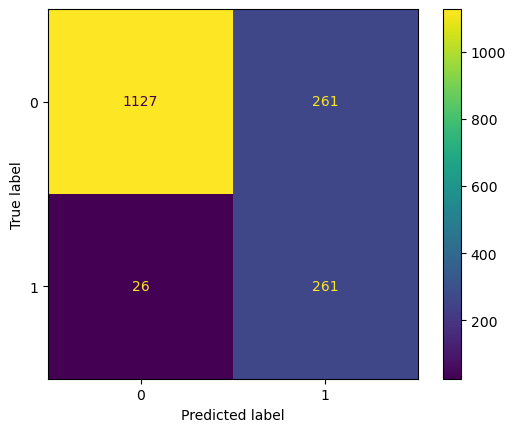

In [196]:
# Print Classification Report
print("- Classification Report:")
print(classification_report(y_val, y_log_res_pred))

# Print Model Metrics
print("- Model Metrics:")
print('Model Accuracy:', round((accuracy_score(y_val,y_log_res_pred)*100), 2), '%')
print('Model Precision:', round((precision_score(y_val,y_log_res_pred)*100), 2), '%')
print('Model Recall:', round((recall_score(y_val,y_log_res_pred)*100), 2), '%')
print('Model F1 Score:', round((f1_score(y_val,y_log_res_pred)*100), 2), '%')

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y_val, y_log_res_pred, labels = clf_res.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = clf_res.classes_)

# Display the confusion matrix
disp.plot(values_format='');


ROC AUC: 0.8871


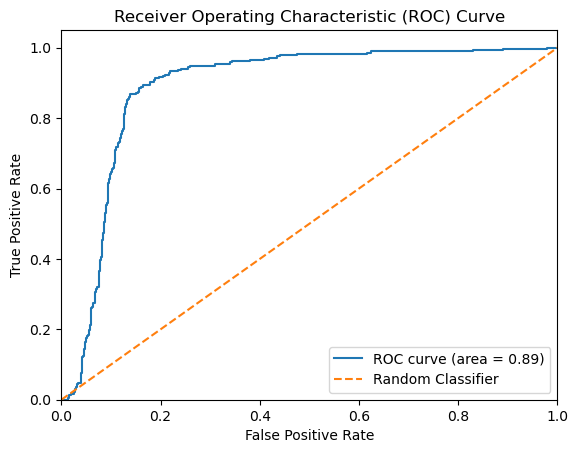

In [197]:
# Predict probabilities for the positive class (class 1) on the test set
y_log_res_pred_proba = clf_res.predict_proba(X_val)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_log_res_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

In [198]:
# Create a table of results for the oversampled logistic regression model
log_res_results_table = pd.DataFrame({
    'Model': 'Oversampled Logistic Regression Model',
    'F1': [f1_score(y_val, y_log_res_pred)],
    'Recall': [recall_score(y_val, y_log_res_pred)],
    'Precision': [precision_score(y_val, y_log_res_pred)],
    'Accuracy': [accuracy_score(y_val, y_log_res_pred)]
})

# Concatenate the results table with results table we cerated earlier
results = pd.concat([log_results_table, log_res_results_table])

# Display the combined results table
results

Model        F1    Recall  Precision  \
0              Logistic Regression Model  0.365639  0.289199   0.497006   
0  Oversampled Logistic Regression Model  0.645241  0.909408   0.500000   

   Accuracy  
0  0.828060  
0  0.828657

After resampling the dataset, the model's recall metric improved significantly. However, the precision and F1-score remain less reliable. To address this, I plan to implement and compare several additional classifiers, including a standard decision tree, a fine-tuned decision tree, a random forest, and an XGBoost classifier.

## **Decision Tree Model**

In [199]:
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=42)

# Fit the model to training data
decision_tree.fit(X_tr, y_tr)

# Make predictions on test data
y_dt_pred = decision_tree.predict(X_val)

- Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1388
           1       0.91      0.91      0.91       287

    accuracy                           0.97      1675
   macro avg       0.95      0.95      0.95      1675
weighted avg       0.97      0.97      0.97      1675

- Model Metrics:
Model Accuracy: 96.96 %
Model Precision: 90.97 %
Model Recall: 91.29 %
Model F1 Score: 91.13 %


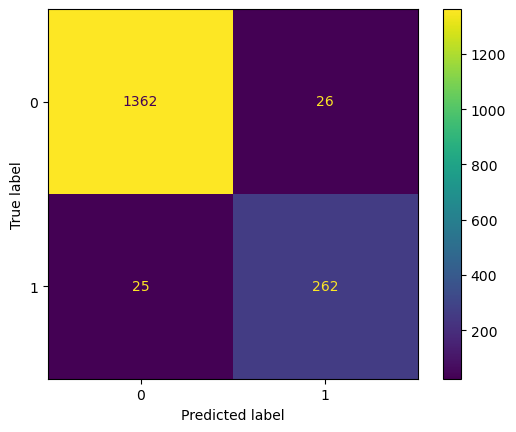

In [200]:
# Print Classification Report
print("- Classification Report:")
print(classification_report(y_val, y_dt_pred))

# Print Model Metrics
print("- Model Metrics:")
print('Model Accuracy:', round((accuracy_score(y_val,y_dt_pred)*100), 2), '%')
print('Model Precision:', round((precision_score(y_val,y_dt_pred)*100), 2), '%')
print('Model Recall:', round((recall_score(y_val,y_dt_pred)*100), 2), '%')
print('Model F1 Score:', round((f1_score(y_val,y_dt_pred)*100), 2), '%')

# Calculate the values for each quadrant in the confusion matrix
cm = confusion_matrix(y_val, y_dt_pred, labels = decision_tree.classes_)

# Create the confusion matrix as a visualization
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = decision_tree.classes_)

# Display the confusion matrix
disp.plot(values_format='');


ROC AUC: 0.9471


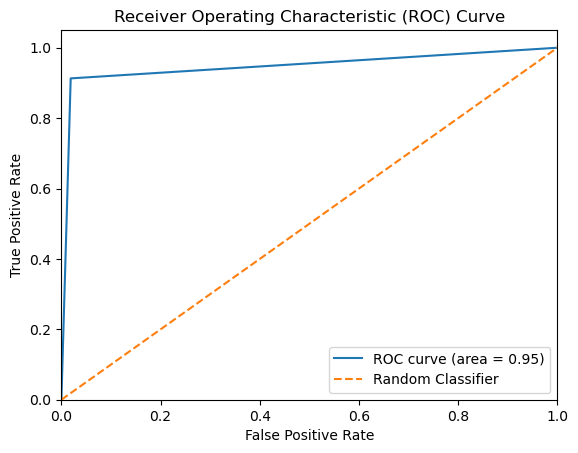

In [201]:
# Predict probabilities for the positive class (class 1) on the validation set
y_dt_pred_proba = decision_tree.predict_proba(X_val)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_dt_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

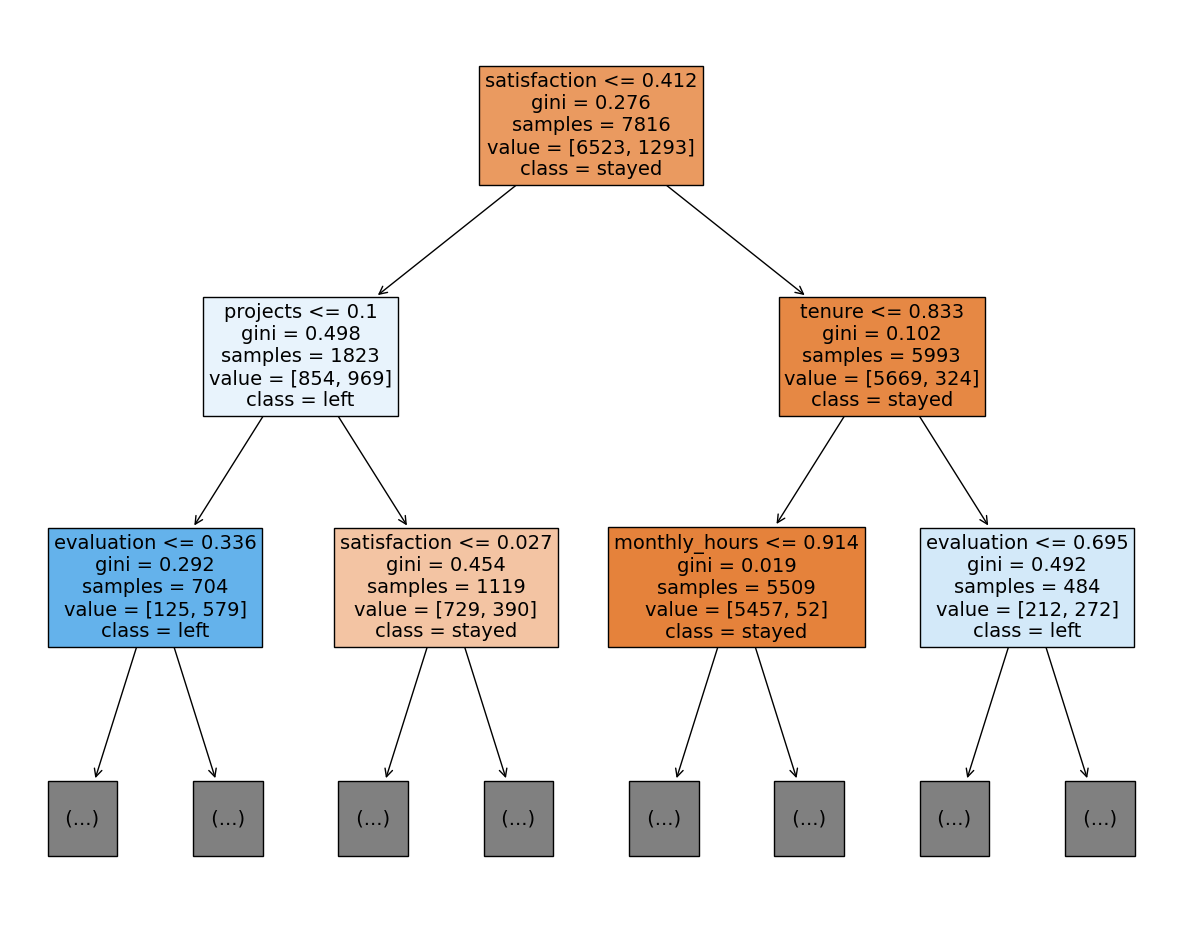

In [202]:
# Plot the top part of the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [203]:
# Create a table of results for the Decision Tree model
dt_results_table = pd.DataFrame({
    'Model': 'Decision Tree Model',
    'F1': [f1_score(y_val, y_dt_pred)],
    'Recall': [recall_score(y_val, y_dt_pred)],
    'Precision': [precision_score(y_val, y_dt_pred)],
    'Accuracy': [accuracy_score(y_val, y_dt_pred)]
})

# Concatenate the results table with the existing results table
results = pd.concat([results, dt_results_table])

# Display the combined results table
results

Model        F1    Recall  Precision  \
0              Logistic Regression Model  0.365639  0.289199   0.497006   
0  Oversampled Logistic Regression Model  0.645241  0.909408   0.500000   
0                    Decision Tree Model  0.911304  0.912892   0.909722   

   Accuracy  
0  0.828060  
0  0.828657  
0  0.969552

Now that the decision tree model has demonstrated significantly better metrics, the next step is to perform a grid search to fine-tune its hyperparameters, with the aim of achieving even better results.

In [204]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

# Assign a set of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [205]:
%%time
# Instantiate the GridSearch refit on f1-score as it leverages both precision and recall
dt_cv = GridSearchCV(tuned_decision_tree,
                   tree_para,
                   scoring = scoring,
                   cv=5,
                   refit="f1")

# Fit the model
dt_cv.fit(X_tr, y_tr)

CPU times: user 4.36 s, sys: 38.6 ms, total: 4.4 s
Wall time: 4.54 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

I will evaluate the performance using the F1-score, as it effectively balances both precision and recall:

In [206]:
# Examine the best f1-score from GridSearch
dt_cv.best_estimator_
print("Best Avg. Validation F1-score Score: ", "%.4f" % dt_cv.best_score_)

Best Avg. Validation F1-score Score:  0.9473


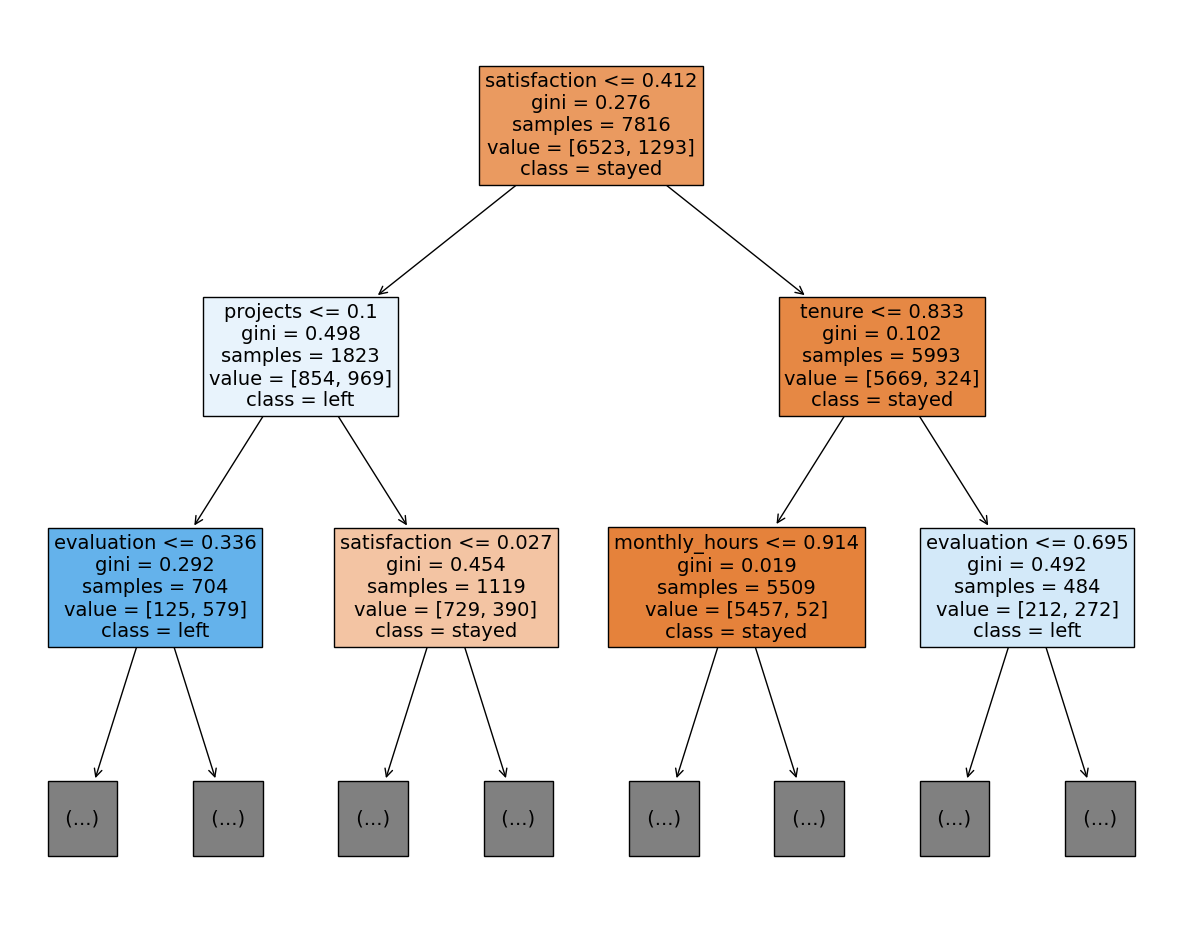

In [207]:
# Plot the top part of the tuned decision tree
plt.figure(figsize=(15, 12))
plot_tree(dt_cv.best_estimator_, max_depth=2, fontsize=14, feature_names=X.columns,
          class_names={0: 'stayed', 1: 'left'}, filled=True)
plt.show()


ROC AUC: 0.9677


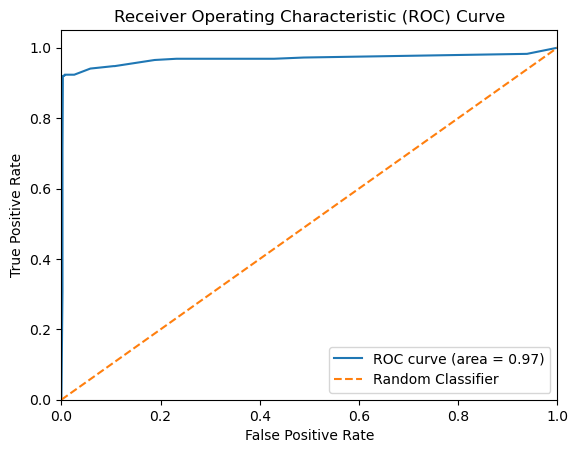

In [208]:
# Predict probabilities for the positive class (class 1) on the validation set
y_dt_cv_pred_proba = dt_cv.best_estimator_.predict_proba(X_val)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and
# thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_dt_cv_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

Now, I'll define a function to quickly compile the performance metrics into a single table for easy comparison:

In [209]:
# Define a function to create a tabel of the metrics of models that uses grid search
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1-score, recall, precision, and accuracy scores
    for the model with the best F1-score for the validation dataset.
    '''

    # Get the best model from GridSearchCV
    best_model = model_object.best_estimator_

    # Predict on the test set
    y_pred = best_model.predict(X_val)

    # Calculate metrics on the test set
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )

    return table

# Create a results table for the tuned decision tree model
dt_cv_results_table = make_results("Tuned Decision Tree Model", dt_cv)

# Concatenate the results table with the existing results table
results = pd.concat([results, dt_cv_results_table])

# Display the combined results table
results

Model        F1    Recall  Precision  \
0              Logistic Regression Model  0.365639  0.289199   0.497006   
0  Oversampled Logistic Regression Model  0.645241  0.909408   0.500000   
0                    Decision Tree Model  0.911304  0.912892   0.909722   
0              Tuned Decision Tree Model  0.946237  0.919861   0.974170   

   Accuracy  
0  0.828060  
0  0.828657  
0  0.969552  
0  0.982090

## **Random Forest Model**

In [210]:
# Create list of split indices
split_index = [0 if x in X_val.index else -1 for x in X_tr.index]

In [211]:
# Initialize the RandomForestClassifier with a random state and balanced class weights
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Define the parameter grid for cross-validation
cv_params = {
    'max_depth': [2, 3, 4, 5, None],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'max_features': [2, 3, 4],
    'n_estimators': [75, 100, 125, 150]
}

# Define the scoring metrics to be used during cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Create a custom split using a predefined split index
custom_split = PredefinedSplit(split_index)

# Initialize GridSearchCV with the RandomForestClassifier, parameter grid, scoring metrics, custom split, and refit based on F1 score
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=custom_split, refit='f1')


In [212]:
%%time
# # Fit rf_cv into the GridSearchCV
# rf_cv = rf_cv.fit(X_tr, y_tr)

# # Pickle the model
# with open('rf_cv_model.pickle', 'wb') as to_write:
#     pickle.dump(rf_cv, to_write)

# Open pickled model
with open('rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

CPU times: user 3.22 ms, sys: 3.6 ms, total: 6.82 ms
Wall time: 6.72 ms


In [213]:
# Check for best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}


ROC AUC: 0.9802


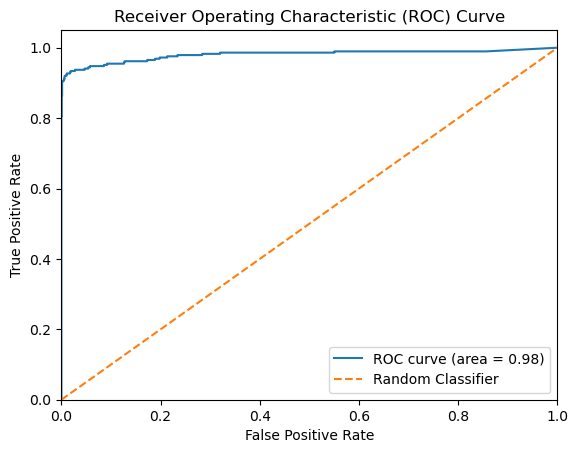

In [214]:
# Predict probabilities for the positive class (class 1) on the validation set
y_rf_pred_proba = rf_cv.best_estimator_.predict_proba(X_val)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_rf_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

In [215]:
# Create a results table for the Random Forest model using the make_results function
rf_cv_results = make_results('Random Forest Model', rf_cv)

# Concatenate the Random Forest model results table with the master results table
results = pd.concat([results, rf_cv_results])

# Display the combined results table
results

Model        F1    Recall  Precision  \
0              Logistic Regression Model  0.365639  0.289199   0.497006   
0  Oversampled Logistic Regression Model  0.645241  0.909408   0.500000   
0                    Decision Tree Model  0.911304  0.912892   0.909722   
0              Tuned Decision Tree Model  0.946237  0.919861   0.974170   
0                    Random Forest Model  0.942029  0.905923   0.981132   

   Accuracy  
0  0.828060  
0  0.828657  
0  0.969552  
0  0.982090  
0  0.980896

## **XGBoost Model**

In [216]:
# Initialize the XGBoost classifier with a binary logistic objective and a random state
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Define the parameter grid for cross-validation
cv_params = {
    'max_depth': [4, 5, 6, 7, 8],
    'min_child_weight': [1, 2, 3, 4, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [75, 100, 125]
}

# Define the scoring metrics to be used during cross-validation
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Initialize GridSearchCV with the XGBoost classifier, parameter grid, scoring metrics, 5-fold cross-validation, and refit based on F1 score
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')


In [217]:
%%time
# # Fit the XGBoost model
# xgb_cv = xgb_cv.fit(X_tr, y_tr)

# # Pickle the model
# with open('xgb_cv_model.pickle', 'wb') as to_write:
#     pickle.dump(xgb_cv, to_write)

# Open pickled model
with open('xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

CPU times: user 2.38 ms, sys: 2.18 ms, total: 4.56 ms
Wall time: 17.2 ms


In [218]:
# Check for best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 75}


ROC AUC: 0.9862


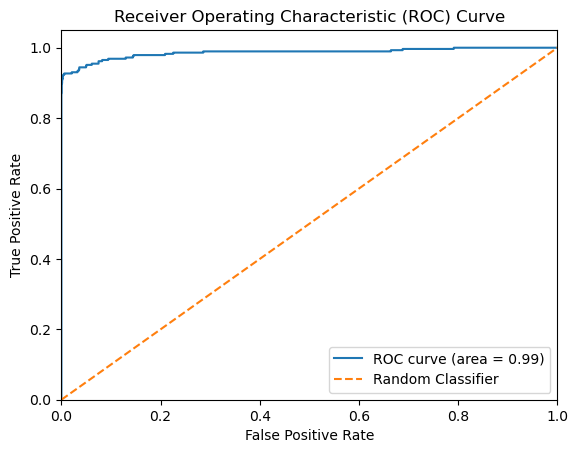

In [219]:
# Predict probabilities for the positive class (class 1) on the validation set
y_xgb_cv_pred_proba = xgb_cv.best_estimator_.predict_proba(X_val)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_val, y_xgb_cv_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

Now, I'll sort all the models based on their F1-score, from best to worst, to select the champion model:

In [220]:
# Create a results table for the XGBoost CV model using the make_results function
xgb_cv_results = make_results('XGBoost CV Model', xgb_cv)

# Concatenate the XGBoost CV model results table with the master results table
results = pd.concat([results, xgb_cv_results])

# Sort the master results table by F1 score in descending order
results = results.sort_values(by=['F1'], ascending=False)

# Display the combined and sorted results table
results

Model        F1    Recall  Precision  \
0                       XGBoost CV Model  0.947559  0.912892   0.984962   
0              Tuned Decision Tree Model  0.946237  0.919861   0.974170   
0                    Random Forest Model  0.942029  0.905923   0.981132   
0                    Decision Tree Model  0.911304  0.912892   0.909722   
0  Oversampled Logistic Regression Model  0.645241  0.909408   0.500000   
0              Logistic Regression Model  0.365639  0.289199   0.497006   

   Accuracy  
0  0.982687  
0  0.982090  
0  0.980896  
0  0.969552  
0  0.828657  
0  0.828060

## **Best Model Results**



From the above results tables, we can see that the best model that fits the data and score the best f1-score (which gives a score for both retention and turnover) is the **XGBoost Model**, now we'll test the model on the testing holdout dataset to get the final score for this model:

In [221]:
# Get the best model from GridSearchCV
best_model = xgb_cv.best_estimator_

# Predict on the test set
y_test_pred = best_model.predict(X_test)

# Calculate metrics on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

# Create table of results
table = pd.DataFrame({'Model': 'Best ML Model',
                      'F1': [f1],
                      'Recall': [recall],
                      'Precision': [precision],
                      'Accuracy': [accuracy]
                      }
                    )
# View results table
table

Model        F1    Recall  Precision  Accuracy
0  Best ML Model  0.962457  0.933775   0.992958  0.986874


ROC AUC: 0.9881


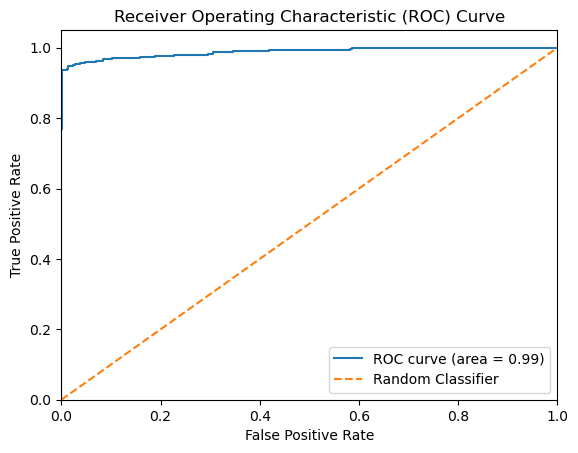

In [222]:
# Predict probabilities for the positive class (class 1) on the test set
y_champion_pred_proba = xgb_cv.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate the false positive rate (FPR), true positive rate (TPR), and thresholds for the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_champion_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Print the ROC AUC value
print(f"\nROC AUC: {roc_auc:.4f}")

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

# Set the limits for the x and y axes
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Set the labels for the x and y axes
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the title of the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc="lower right")

# Display the plot
plt.show()

That's excellent! The model achieved even higher performance on the testing data compared to the training or validation sets.

# pacE: Execute Stage



Now let's see what features are the most influential in employees leaving or staying in the company:

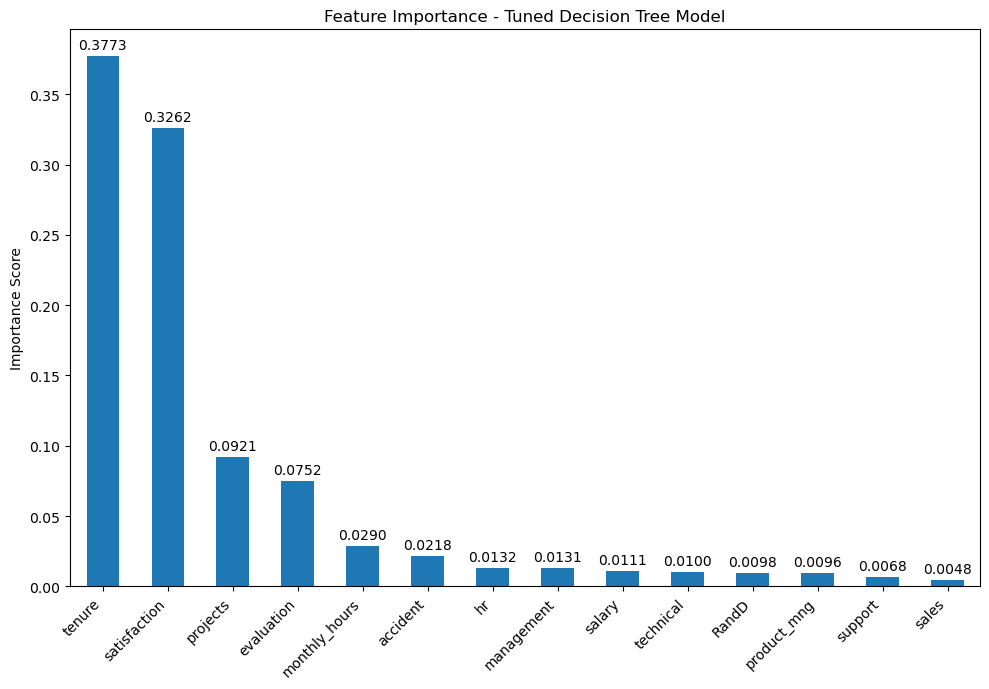

In [223]:
# Extract feature importances from the champion model
importances = xgb_cv.best_estimator_.feature_importances_

# Create a Series of feature importances, sorted in descending order
best_model_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

# Filter out importances that are 0 or less
best_model_importances = best_model_importances[best_model_importances > 0]

# Create a bar plot of the feature importances with a wider figure size
fig, ax = plt.subplots(figsize=(10, 7))  # Adjust the width and height for a wider plot
best_model_importances.plot.bar(ax=ax)

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set title and labels
plt.title("Feature Importance - Tuned Decision Tree Model")
plt.ylabel("Importance Score")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed

plt.tight_layout()
plt.show()

From the above plot based on the model, we can see the following:
* **Employee tenure & satisfaction are the major influences in employees decision to leave or stay.**
* The **third and forth reasons** why employees leave is their **number of project contributions** and **evaluation (last performance review)**
* After those comes the average number of hours employee worked per month.
* The rest of the variables have little to zero effect on whether an employess will leave the company or stay.

From the above plot based on the model, we can see the following:
1. **Tenure (Time Spent at the Company)**

  •	**Insight**: Employees with less than 3 years or more than 6 years at the company are less likely to leave. Middle-tenure employees (3–6 years) may be at higher risk of leaving.

  •	**Recommendation**: Develop retention strategies specifically targeting mid-tenure employees. This could include promotions, and development opportunities.

2. **Satisfaction Level**

  •	**Insight**: Satisfaction is the second most important predictor of whether an employee will leave the company. Employees with lower satisfaction levels are significantly more likely to leave.

  •	**Recommendation**: Focus on strategies to improve job satisfaction across the board. Regular surveys, better recognition programs, and flexible working conditions could be pivotal in retaining employees.

3. **Number of Projects**

  •	**Insight**: Employees handling a lower number of projects are more likely to leave the company.

  •	**Recommendation**: Evaluate workload distribution. Employees who are underutilized might feel disengaged or under-challenged, leading to a higher likelihood of turnover.

4. **Last Evaluation**

  •	**Insight**: Employees with extremely high or low evaluations are more likely to leave. Average-performing employees tend to stay.

  •	**Recommendation**: Investigate the reasons why highly evaluated employees might leave, possibly due to burnout or lack of upward mobility. Ensure that underperforming employees receive sufficient support to improve their performance.


5. **Monthly Hours Worked**

  •	**Insight**: Similar to evaluations, employees who work very few or too many hours per month are more likely to leave. Those with a more balanced workload tend to stay.

  •	**Recommendation**: Regularly assess workload and redistribute it as necessary to avoid both underwork and overwork, which can lead to dissatisfaction and attrition.

6. **Work Accidents**

  •	**Insight**: The model indicates that having experienced a work accident has very little importance in predicting employee turnover. This suggests that, while accidents may occur, they are not a significant factor in employees’ decisions to leave.

  •	**Recommendation**: Even though work accidents don’t strongly impact turnover in the model, it’s still crucial to maintain a safe and supportive work environment. Implement robust safety protocols and ensure employees feel supported after accidents to foster trust and long-term loyalty.



Although the data shows that tenure is statistically the most important factor in predicting employee departures, followed by job satisfaction, we need to delve deeper to understand why mid-tenure employees are leaving and what truly influences satisfaction levels.

From my exploratory data analysis (EDA), it's evident that overworked employees—those with longer working hours and involvement in numerous projects—tend to leave more frequently. This suggests that workload may be a key driver of job satisfaction. It’s possible that employees try to cope with the demanding work environment for a few years, but by their third or fourth year, they reach a breaking point and decide to quit.

To explore this further, we can refine our analysis by excluding variables that don’t lead to actionable insights, such as satisfaction and tenure, and refit the model with more targeted factors.

### Evaluation of Model Performance

The model's performance metrics are as follows:

- **F1 Score**: This score combines both the model's ability to correctly identify employees who will leave (recall) and the accuracy of those predictions (precision). Our model scored 96.25%, which is very high and indicates that it is excellent at both identifying potential leavers and being accurate in those predictions.

- **Recall**: This measures how well the model identifies employees who are actually going to leave. Our model scored 93.38%, meaning it correctly identifies almost all employees who are likely to leave.

- **Precision**: This measures how accurate the model is when it predicts that an employee will leave. Our model scored 99.30%, indicating that when the model predicts an employee will leave, it is almost always correct.

- **Accuracy**: This measures how often the model is correct overall. Our model scored 98.69%, meaning it is correct almost all the time.

- **ROC AUC**: This is a single number that summarizes the model's ability to distinguish between employees who will leave and those who won't. Our model scored 98.81%, which is very high and indicates that the model is extremely effective at this task.

These high scores indicate that our model is highly effective and reliable in predicting employee turnover. This means you can trust the model's predictions to help you make informed decisions about employee retention strategies. The model is not only accurate but also very good at identifying the employees who are most likely to leave, allowing you to take proactive measures to retain them.

#### Actionable Steps

1. **Target Mid-Tenure Employees**: Develop retention strategies such as promotions and development opportunities for employees with 3-6 years of tenure.
2. **Improve Job Satisfaction**: Implement regular surveys, recognition programs, and flexible working conditions.
3. **Evaluate Workload Distribution**: Ensure balanced workloads to avoid underwork and overwork.
4. **Investigate High/Low Evaluations**: Address burnout and lack of upward mobility for highly evaluated employees, and provide support for underperforming employees.
5. **Maintain Safety Protocols**: Implement robust safety protocols and support employees after accidents.
6. **Fair Compensation and Non-Monetary Value**: Ensure employees feel fairly compensated and valued through career growth, recognition, and a positive work environment.
7. **Address Department-Specific Issues**: Conduct department-specific engagement surveys and address unique challenges within high-turnover departments.

### Conclusion

The model effectively identifies key factors contributing to employee turnover and provides actionable insights to improve retention. The high performance metrics indicate that the model is reliable for making data-driven decisions.

### Recommendations

1. **Focus on Improving Job Satisfaction**: Regular surveys and recognition programs can help identify and address dissatisfaction, especially between mid-tenure employees.
2. **Ensure Balanced Workloads and Fair Compensation**: Balanced workloads and fair compensation can help retain employees.
3. **Investigate High Turnover Departments**: Conduct department-specific engagement surveys to understand and address unique challenges.
4. **Implement Robust Safety Protocols**: Enhance safety protocols and provide support for employees involved in accidents.

### Next Steps

1. **Implement Recommendations**: Start with the most impactful recommendations, such as improving job satisfaction for mid -tenure employees.
2. **Monitor and Evaluate**: Continuously monitor the effectiveness of the implemented strategies and make adjustments as needed.
3. **Enhance the Model**: Incorporate additional features such as employee engagement scores, managerial support ratings, and career growth opportunities to further improve the model's predictive power.
4. **Conduct Further Analysis**: Investigate the primary reasons for dissatisfaction, effective retention strategies for mid-tenure employees, and the impact of workload distribution on engagement and satisfaction. **We can also refine our analysis by excluding variables that don’t lead to actionable insights, such as satisfaction and tenure, and refit the model with more targeted factors.**